In [30]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
#making this plot wider
options(repr.plot.width=30, repr.plot.height=15)

In [3]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [4]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

In [5]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps_norm, Kingdom=="Bacteria")
ps_norm_bac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 103479 taxa and 92 samples ]
sample_data() Sample Data:       [ 92 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 103479 taxa by 6 taxonomic ranks ]

In [6]:
#remove chloroplast order
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")
ps_norm_nochlo

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 78429 taxa and 92 samples ]
sample_data() Sample Data:       [ 92 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 78429 taxa by 6 taxonomic ranks ]

In [7]:
theme_set(theme_bw())

### plot no chloroplast using glom

comparing Date_16S

In [8]:
ps_norm_nochlo_glom=tax_glom(ps_norm_nochlo, taxrank="Order")

In [9]:
top10 <- names(sort(taxa_sums(ps_norm_nochlo_glom), decreasing=TRUE))[1:10] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps_norm_nochlo_glom_top10 <- prune_taxa(top10, ps_norm_nochlo_glom) 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


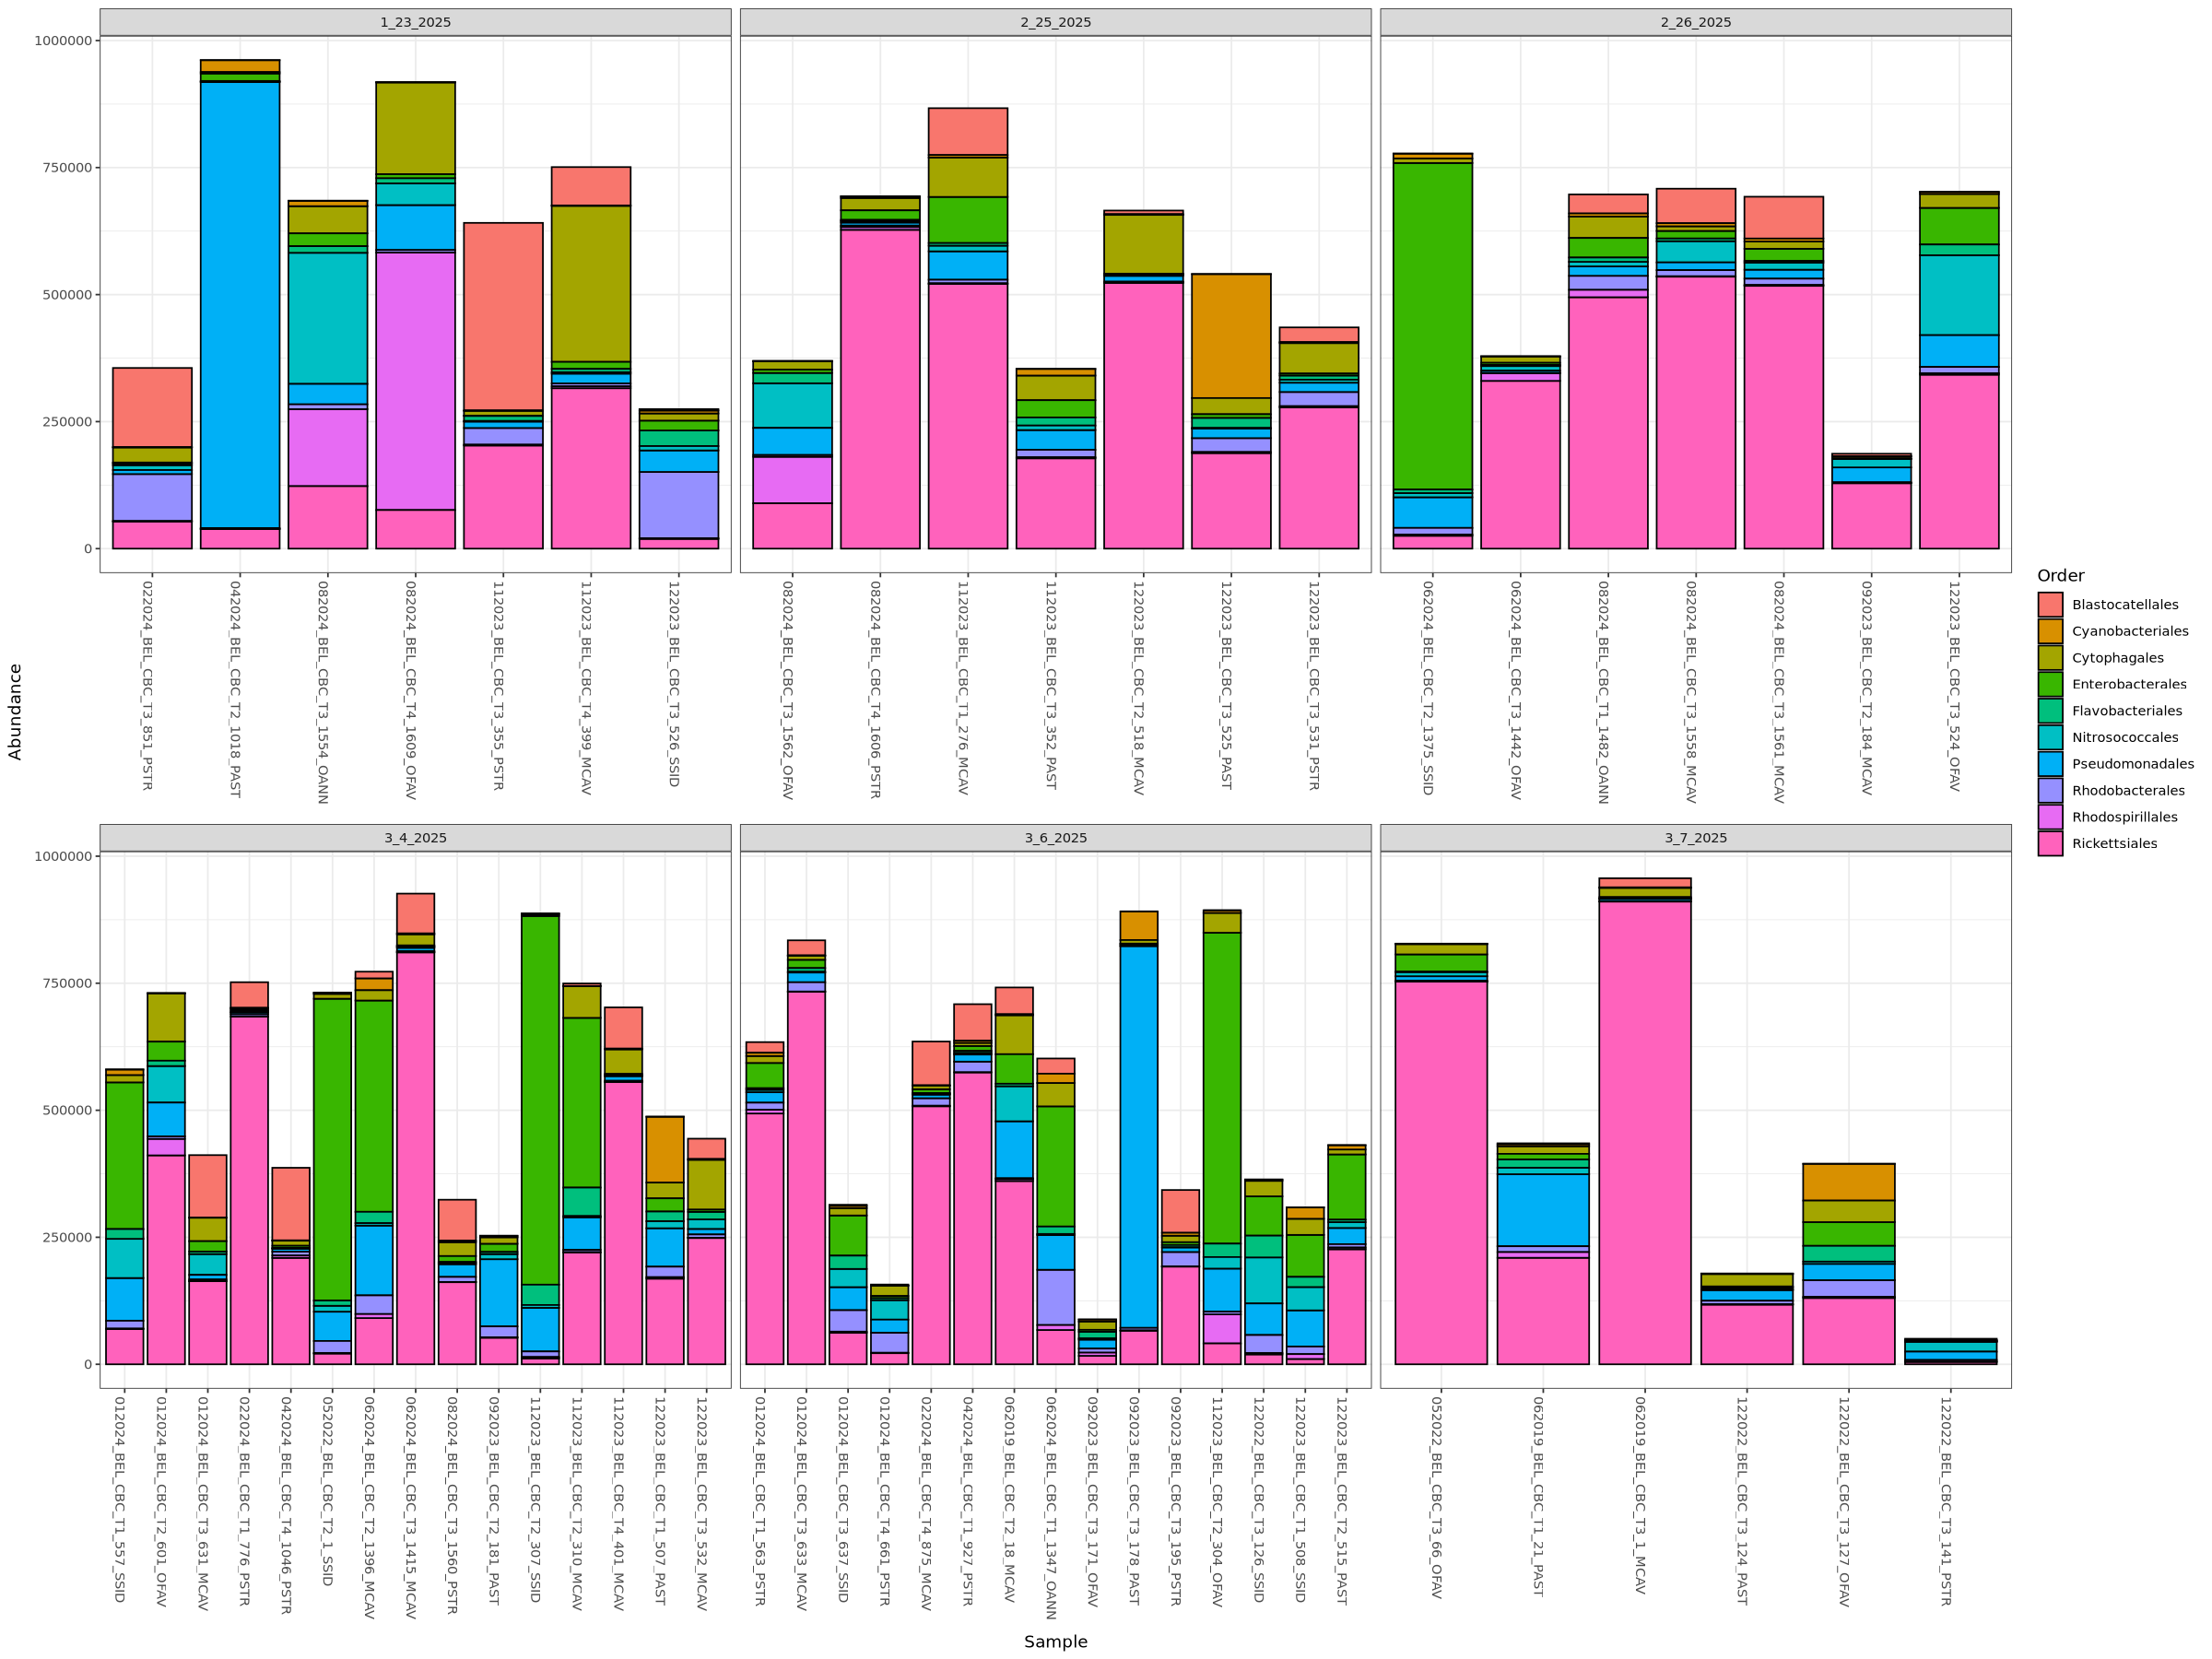

In [10]:
plot_bar(ps_norm_nochlo_glom_top10, fill="Order")+ facet_wrap(~Date_16S, scales="free_x")

### plot no chloroplast within phyloseq
comparing species

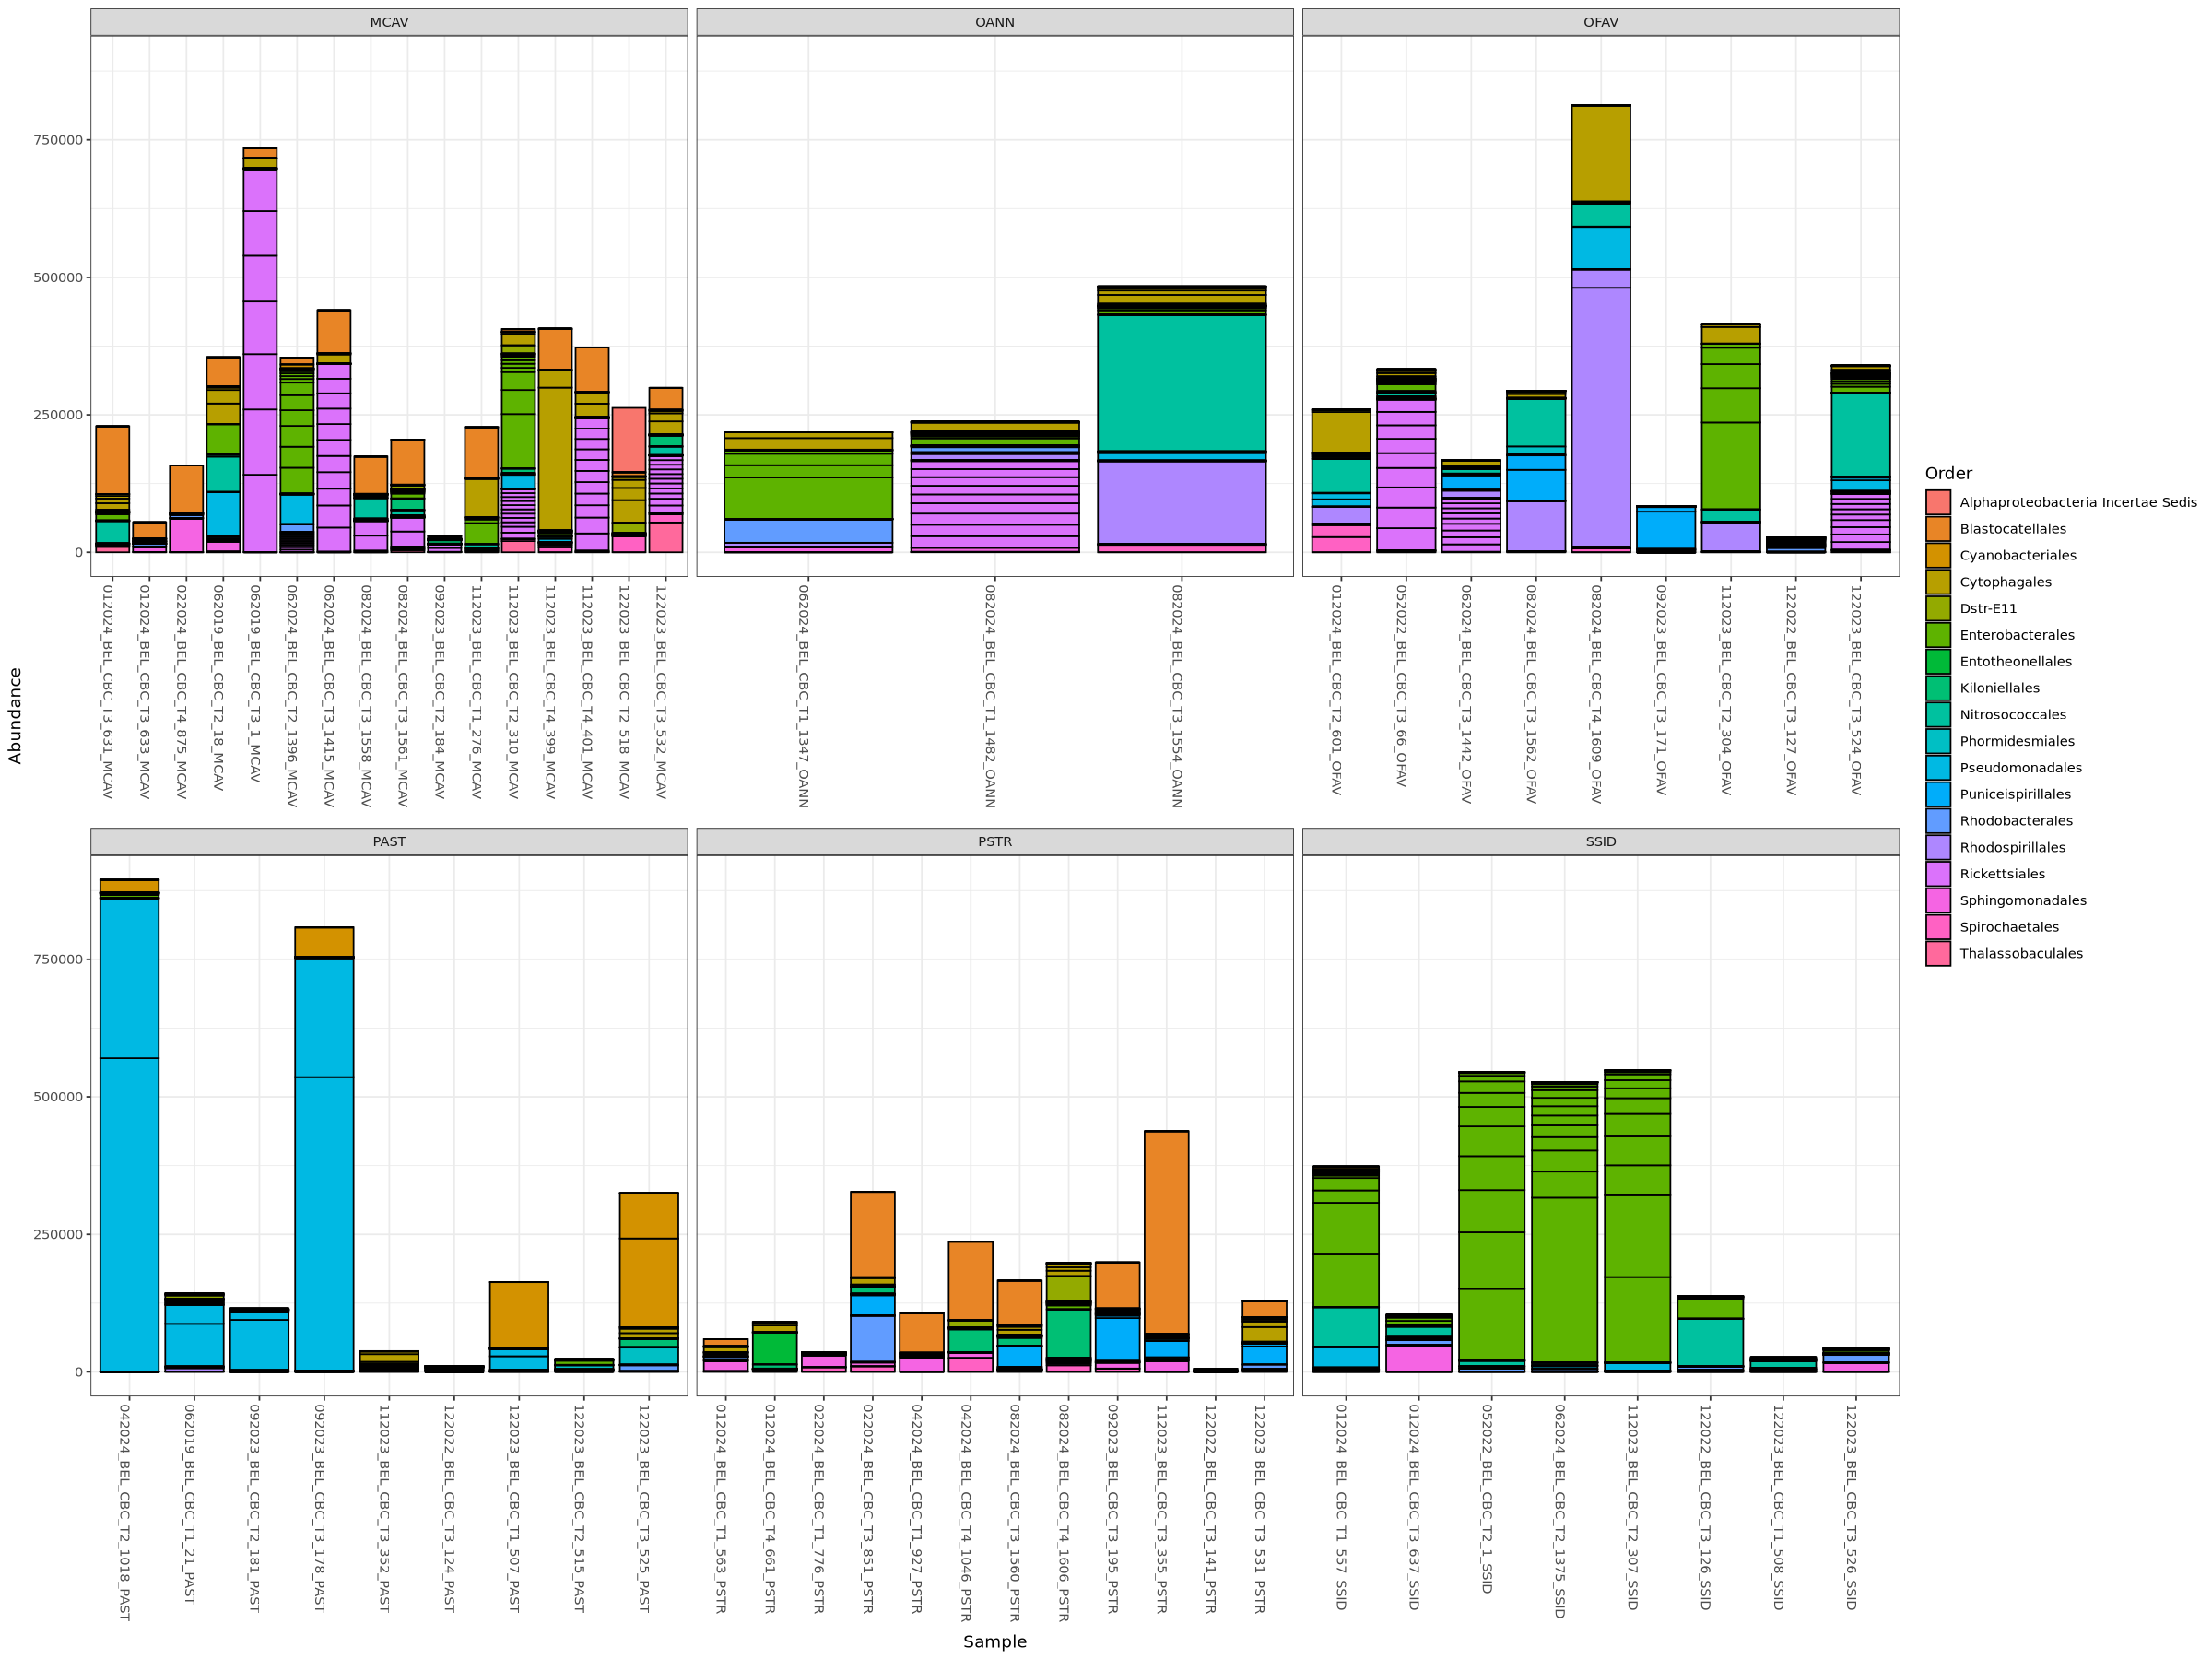

In [11]:
#plot after removing chloroplast
top100 <- names(sort(taxa_sums(ps_norm_nochlo), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100 <- prune_taxa(top100, ps_norm_nochlo) 
plot_bar(ps.top100, fill="Order") + facet_wrap(~species, scales="free_x")

### remove mitochondria, I think is being overrep in MCAV and OANN family level

In [8]:
#remove mitochondria family
ps_norm_nomit=subset_taxa(ps_norm_nochlo, Family!="Mitochondria")
ps_norm_nomit

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 46475 taxa and 92 samples ]
sample_data() Sample Data:       [ 92 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 46475 taxa by 6 taxonomic ranks ]

In [ ]:
plot_bar(ps_norm_nomit, fill="Phylum")+
geom_bar(aes(color=Phylum, fill=Phylum), stat="identity", position="stack")

#### some have abundances of 750,000, some have abundances of 100k

In [9]:
#sizing plots
options(repr.plot.width=30, repr.plot.height=18)

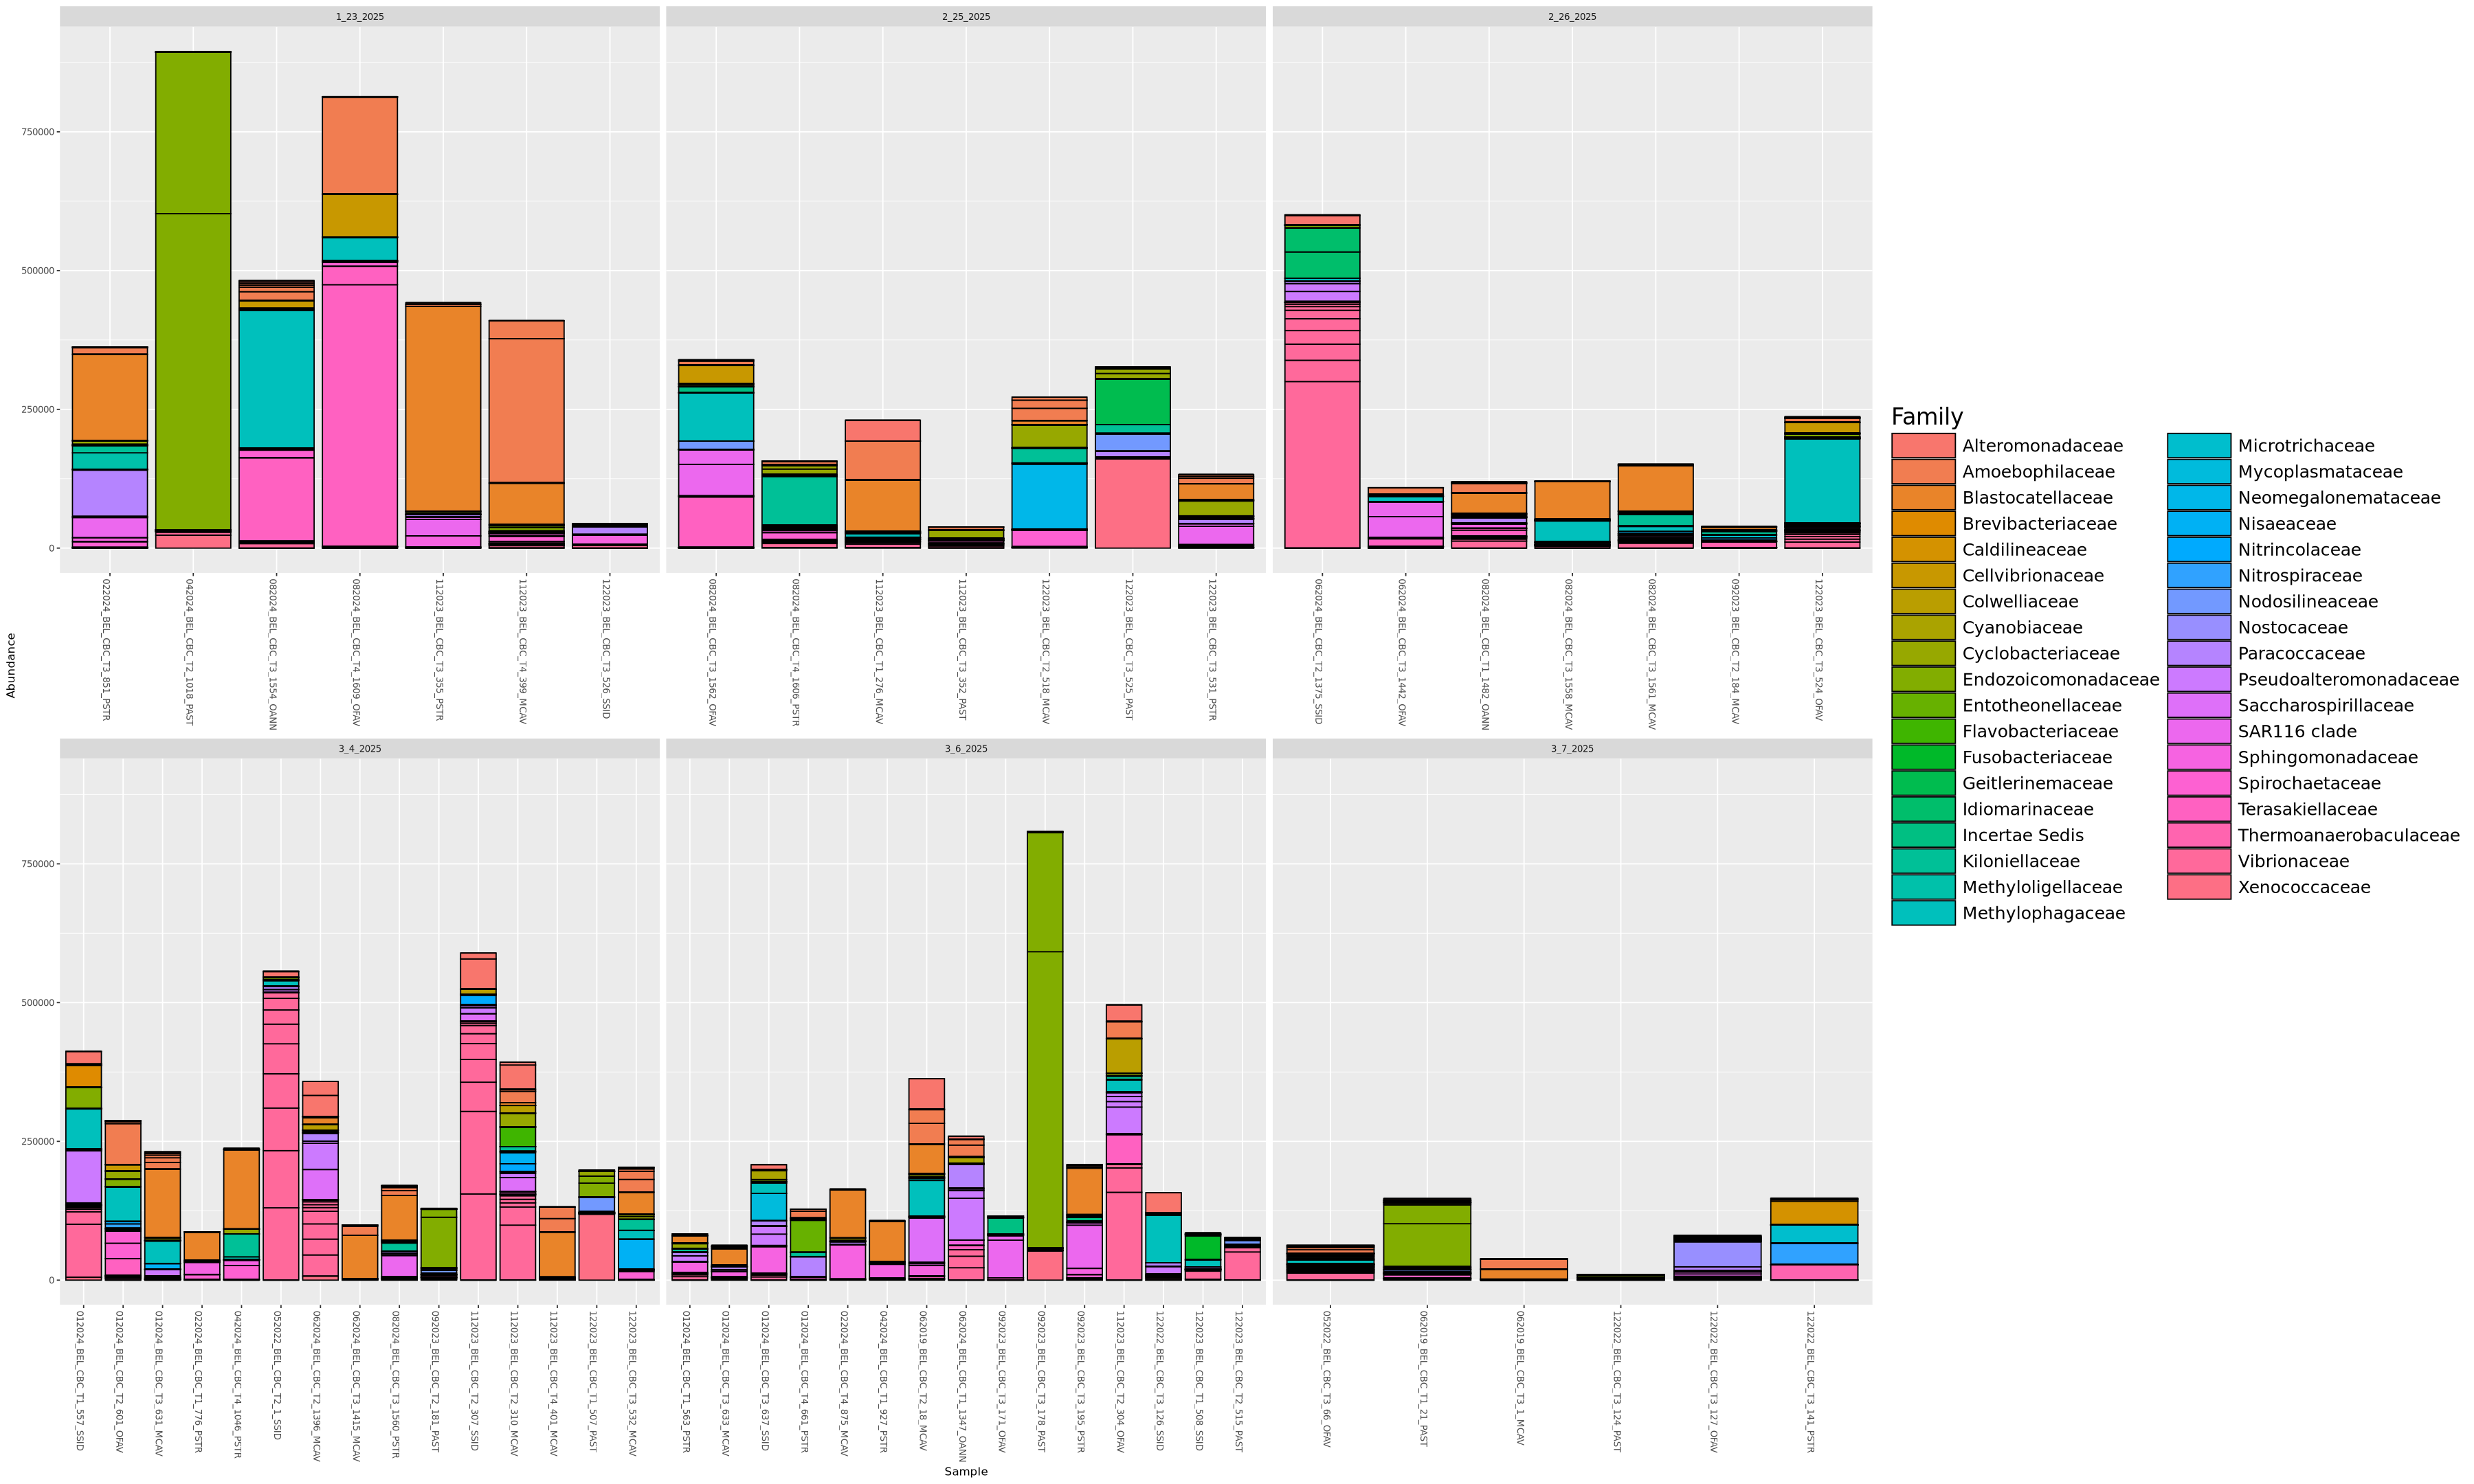

In [12]:
#plot after removing chloroplast
top100_nomit <- names(sort(taxa_sums(ps_norm_nomit), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100_nomit <- prune_taxa(top100_nomit, ps_norm_nomit) 
plot_bar(ps.top100_nomit, fill="Family") + 
theme(
  legend.position = "right", 
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 10),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 8)))+
facet_wrap(~Date_16S, scales="free_x") 

### great now test this but separate by colony

### clean up colony

In [9]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm_nomit) {
  sd_nomit <- sample_data(ps_norm_nomit)
  return(as(sd_nomit,"data.frame"))
}
#using phyloseq nmds plot no chloroplast
sample_nomit <- pssd2veg(ps_norm_nomit)

In [10]:
sample_nomit <- as.data.frame(sample_data(ps_norm_nomit))
#save sammple names as a column so tidy doesn't get rid of it during filtering
sample_nomit$SampleID <- rownames(sample_nomit)

In [11]:
# Return names which have more than one row of data
# Now filter
sample_clean <- sample_nomit %>%
  group_by(colony) %>%
  filter(n() != 1) %>%
  ungroup()

In [12]:
nrow(sample_nomit)
nrow(sample_clean)

[1] 92

[1] 86

In [13]:
sample_clean <- as.data.frame(sample_clean)
class(sample_clean)

Warning message in class(x) <- tibble_class:
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


[1] "data.frame"

#### make dates be in chronological order

In [14]:
# 1. create proper Date variable
sample_clean$MonthYearDate <- as.Date(
  paste0("01 ", sample_clean$MonthYear),
  format = "%d %b %Y"
)

# 2. reorder MonthYear as a factor in chronological order
sample_clean$MonthYear <- factor(
  sample_clean$MonthYear,
  levels = unique(sample_clean$MonthYear[order(sample_clean$MonthYearDate)])
)


In [15]:
# Restore rownames
rownames(sample_clean) <- sample_clean$SampleID

In [16]:
head(rownames(sample_clean))
NROW(sample_names(ps_norm_nomit))

[1] "012024_BEL_CBC_T1_557_SSID" "012024_BEL_CBC_T1_563_PSTR"
[3] "012024_BEL_CBC_T2_601_OFAV" "012024_BEL_CBC_T2_605_SSID"
[5] "012024_BEL_CBC_T3_627_PAST" "012024_BEL_CBC_T3_631_MCAV"

[1] 92

In [17]:
keep_samples <- rownames(sample_clean)
length(keep_samples)
#how many of the values in keep_samples exist in ps_norm_nomit
sum(keep_samples %in% sample_names(ps_norm_nomit))  # Should be 42

[1] 86

[1] 86

In [18]:
# Prune to keep only those samples
ps_clean <- prune_samples(sample_names(ps_norm_nomit) %in% keep_samples, ps_norm_nomit)

In [19]:
class(ps_clean)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

In [20]:
nrow(sample_data(ps_clean))

[1] 86

In [21]:
all(rownames(sample_clean) %in% sample_names(ps_clean))

[1] TRUE

In [22]:
#take the filtered metadata I just worked on — with cleaned rows, and correct sample names — and replace the old sample data in ps_clean with this cleaned version
sd_clean <- phyloseq::sample_data(sample_clean)
sample_data(ps_clean) <- sd_clean
head(sample_data(ps_clean))

Health_Status colony Date_16S  double_band transect
012024_BEL_CBC_T1_557_SSID Healthy       1_3    3_4_2025  y           T1      
012024_BEL_CBC_T1_563_PSTR Healthy       1_12   3_6_2025              T1      
012024_BEL_CBC_T2_601_OFAV Healthy       2_79   3_4_2025              T2      
012024_BEL_CBC_T2_605_SSID Healthy       2_99   3_10_2025 y           T2      
012024_BEL_CBC_T3_627_PAST Healthy       3_34   3_10_2025 y           T3      
012024_BEL_CBC_T3_631_MCAV Healthy       3_21   3_4_2025              T3      
                           species MonthYear Condition
012024_BEL_CBC_T1_557_SSID SSID    Jan 2024  Healthy  
012024_BEL_CBC_T1_563_PSTR PSTR    Jan 2024  Healthy  
012024_BEL_CBC_T2_601_OFAV OFAV    Jan 2024  Healthy  
012024_BEL_CBC_T2_605_SSID SSID    Jan 2024  CLB      
012024_BEL_CBC_T3_627_PAST PAST    Jan 2024  Healthy  
012024_BEL_CBC_T3_631_MCAV MCAV    Jan 2024  Healthy  
                           GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG
012024_BEL_CBC_T1_557_SSID 43                                                                                                                                                                                                                                       
012024_BEL_CBC_T1_563_PSTR  0                                                                                                                                                                                                                                       
012024_BEL_CBC_T2_601_OFAV  7                                                                                                                                                                                                                                       
012024_BEL_CBC_T2_605_SSID 38                                                                                                                                                                                                                                       
012024_BEL_CBC_T3_627_PAST  0                                                                                                                                                                                                                                       
012024_BEL_CBC_T3_631_MCAV 45                                                                                                                                                                                                                                       
                           GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG
012024_BEL_CBC_T1_557_SSID 578                                                                                                                                                                                                                                      
012024_BEL_CBC_T1_563_PSTR 151                                                                                                                                                                                                                                      
012024_BEL_CBC_T2_601_OFAV 277                                                                                                                                                                                                                                      
012024_BEL_CBC_T2_605_SSID 434                                                                                                                                                                                            

#### testing color and style of colony plot

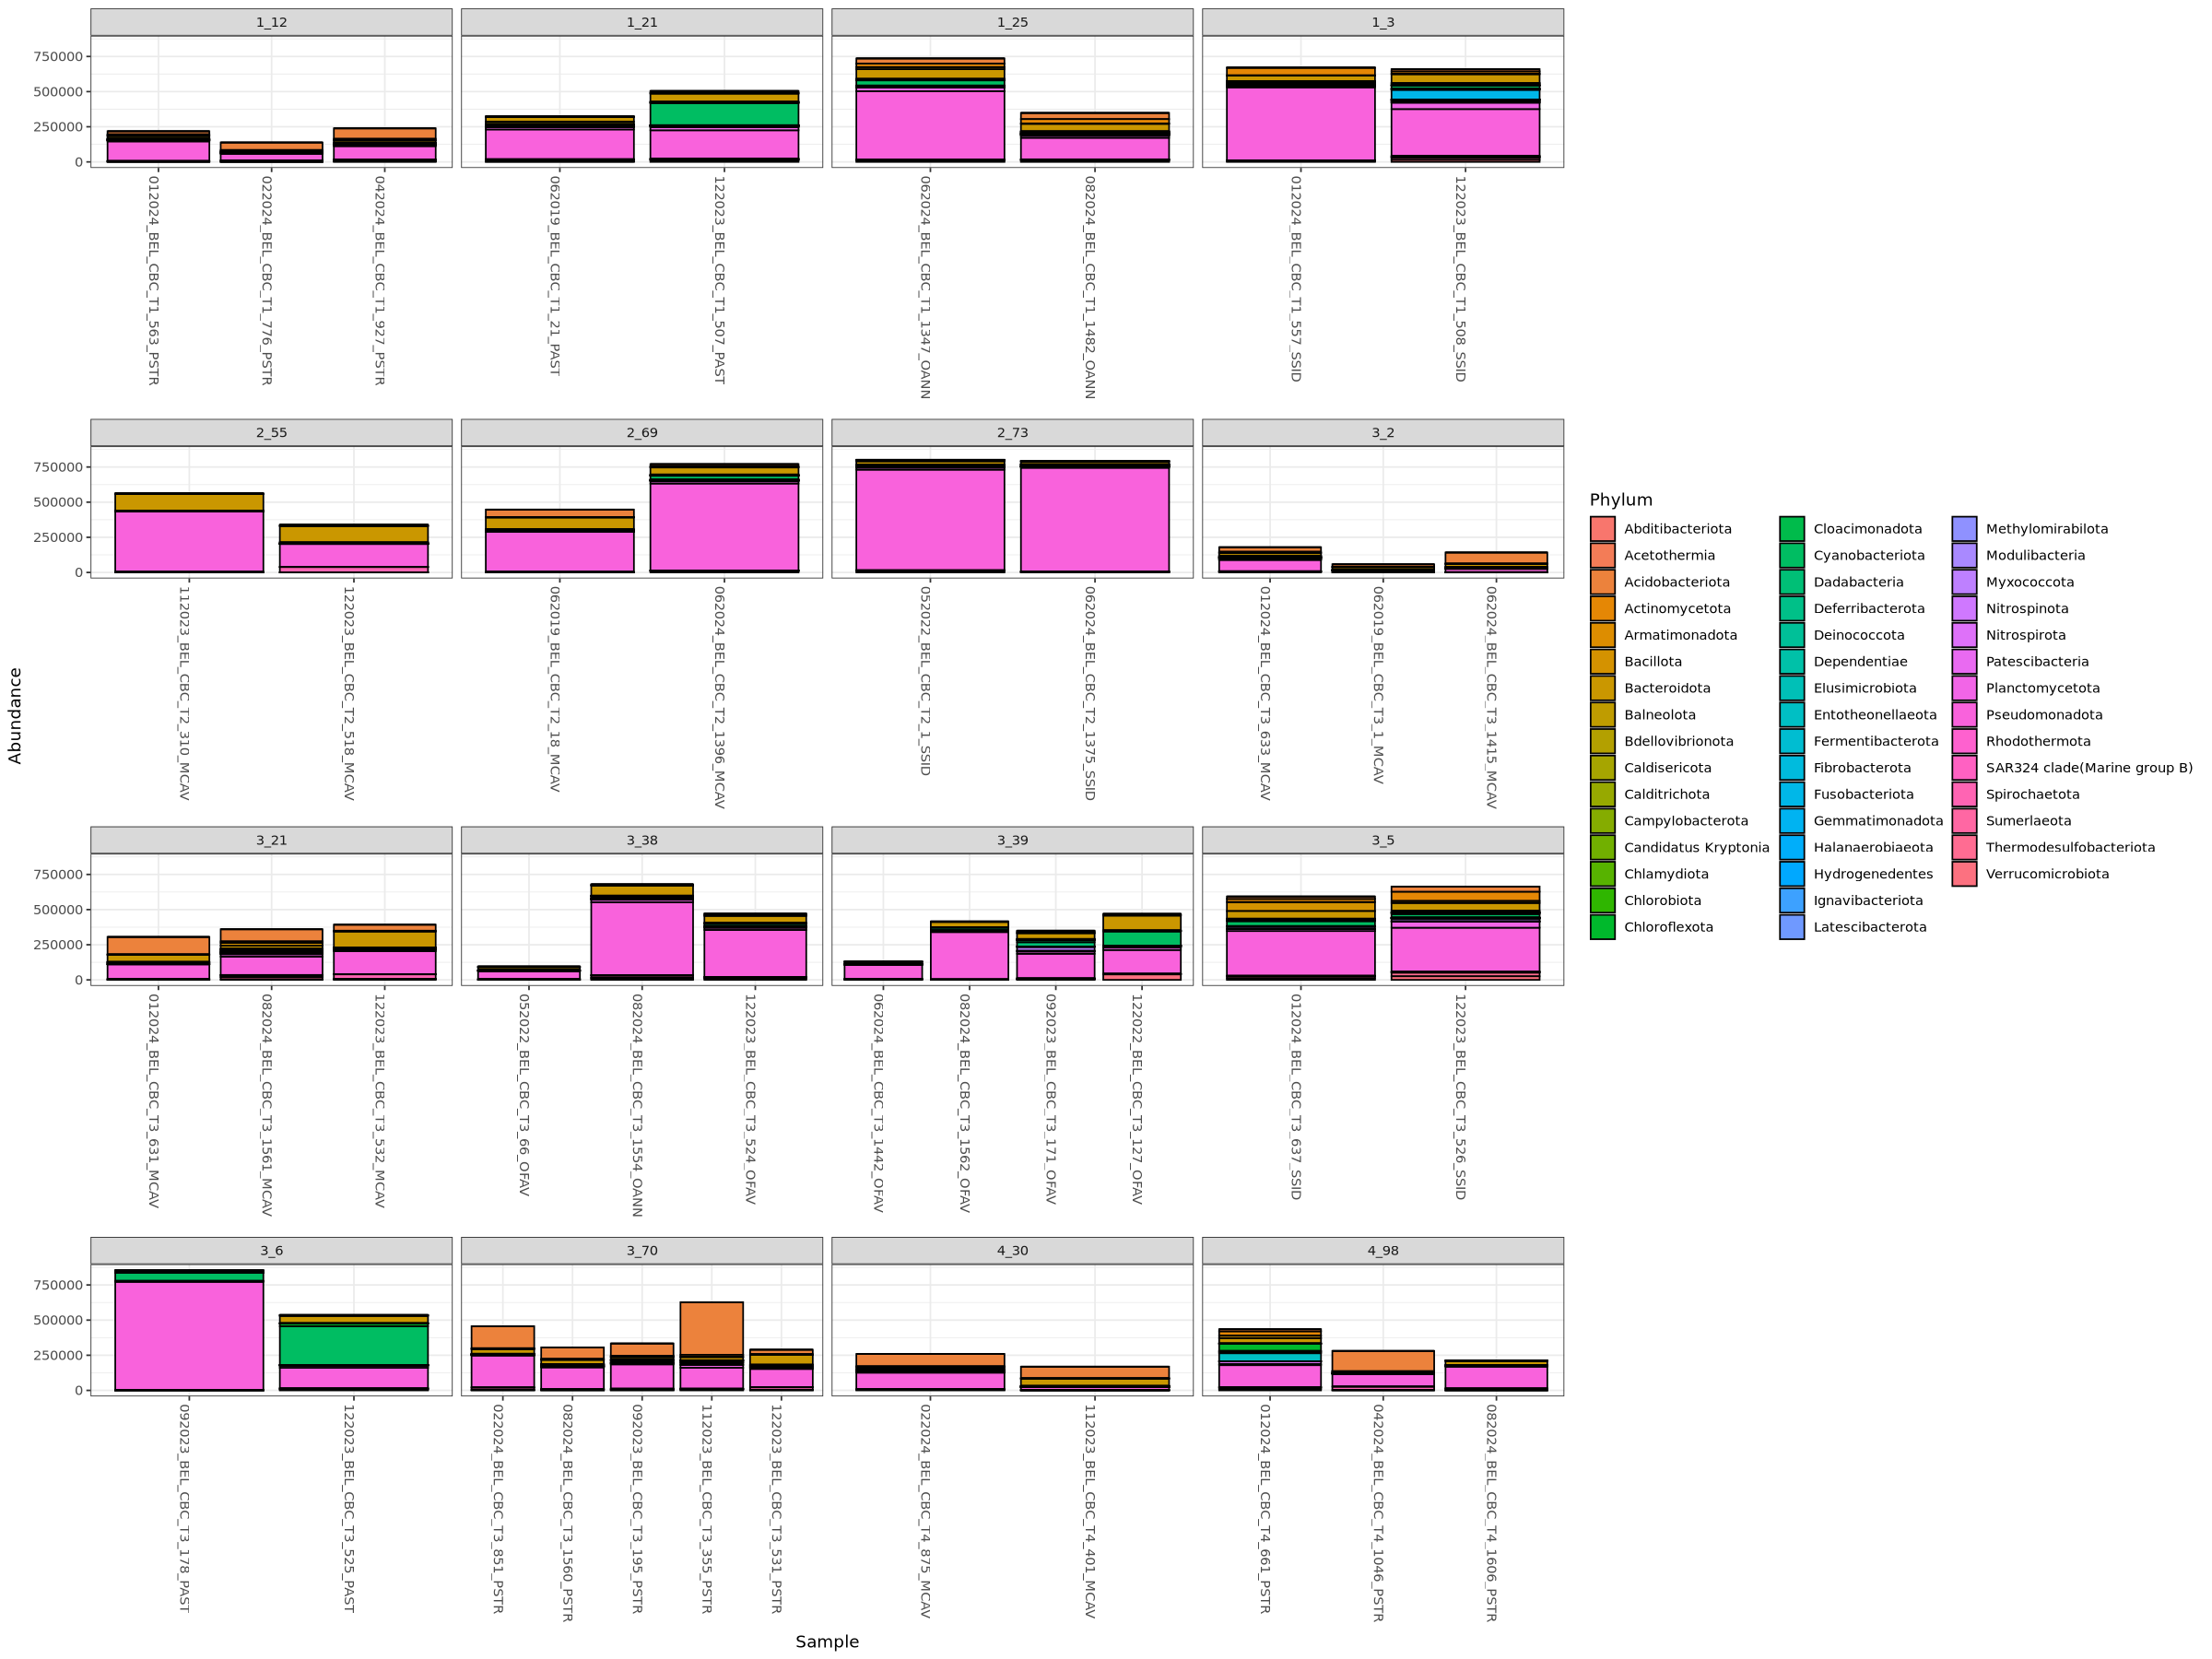

In [61]:
#one style of plot
ps_clean_glom=tax_glom(ps_clean, taxrank="Phylum")
top100_col_glom <- names(sort(taxa_sums(ps_clean_glom), decreasing=TRUE))[1:100]  
ps_clean_glom_top100 <- prune_taxa(top100_col_glom, ps_clean_glom) 
plot_bar(ps_clean_glom_top100, fill="Phylum")+ facet_wrap(~colony, scales="free_x")

## new df for each species based on ps_clean 

In [23]:
#new dataframes for each species 
ps_mcav <- subset_samples(ps_clean, species == "MCAV")
ps_pstr <- subset_samples(ps_clean, species == "PSTR")
ps_ofav <- subset_samples(ps_clean, species == "OFAV")
ps_ssid <- subset_samples(ps_clean, species == "SSID")
ps_oann <- subset_samples(ps_clean, species == "OANN")
ps_past <- subset_samples(ps_clean, species == "PAST") 

In [24]:
#should add up to 89 samples
nrow(sample_data(ps_mcav))
nrow(sample_data(ps_pstr))
nrow(sample_data(ps_ofav))
nrow(sample_data(ps_oann))
nrow(sample_data(ps_ssid))
nrow(sample_data(ps_past))

[1] 25

[1] 15

[1] 16

[1] 4

[1] 10

[1] 16

In [25]:
table(sample_data(ps_clean)[,"colony"])

colony
1_12  1_2 1_21 1_24 1_25  1_3 2_55 2_60 2_63 2_68 2_69 2_73 2_76 2_79 2_99 3_10 
   3    2    2    3    3    3    2    3    2    2    3    3    3    3    2    3 
3_14  3_2 3_21 3_34 3_38 3_39  3_5  3_6 3_66 3_70 4_30 4_76 4_78 4_79 4_98 
   2    3    4    2    3    4    2    3    2    6    2    3    2    2    4 

## Family plots

### comparing family in all coral species

In [26]:
class(ps_clean)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

#### isolating top 50 family taxa in ps_clean

In [27]:
    # how many unique family taxa are there?
length(unique(tax_table(ps_clean)[, "Family"]))

[1] 469

In [28]:
#reduce that to top 50
ps_fam=tax_glom(ps_clean, taxrank= "Family")

#isolating top 50 family taxa
top50<- names(sort(taxa_sums(ps_fam), decreasing=TRUE))[1:50] 
ps_fam <- prune_taxa(top50, ps_fam) 

#confirm that it has been reduced
length(unique(tax_table(ps_fam)[, "Family"]))

[1] 50

#### assigning color to family plots

In [34]:
#assigning colors
famcolors= colorRampPalette(brewer.pal(8, "Accent"))(50)

#Generate a random set of colors based on a df fam_taxa that assigns a random color to each spot in the list
fam_taxa <- unique(tax_table(ps_fam)[, "Family"])
    famcolors <- sample(famcolors, 50, length(fam_taxa))
    # naming my color palette so the random order stays the same
    famcolors<- setNames(famcolors, fam_taxa)

#### plot all species

<Guides[1] ggproto object>

colour : <GuideLegend>

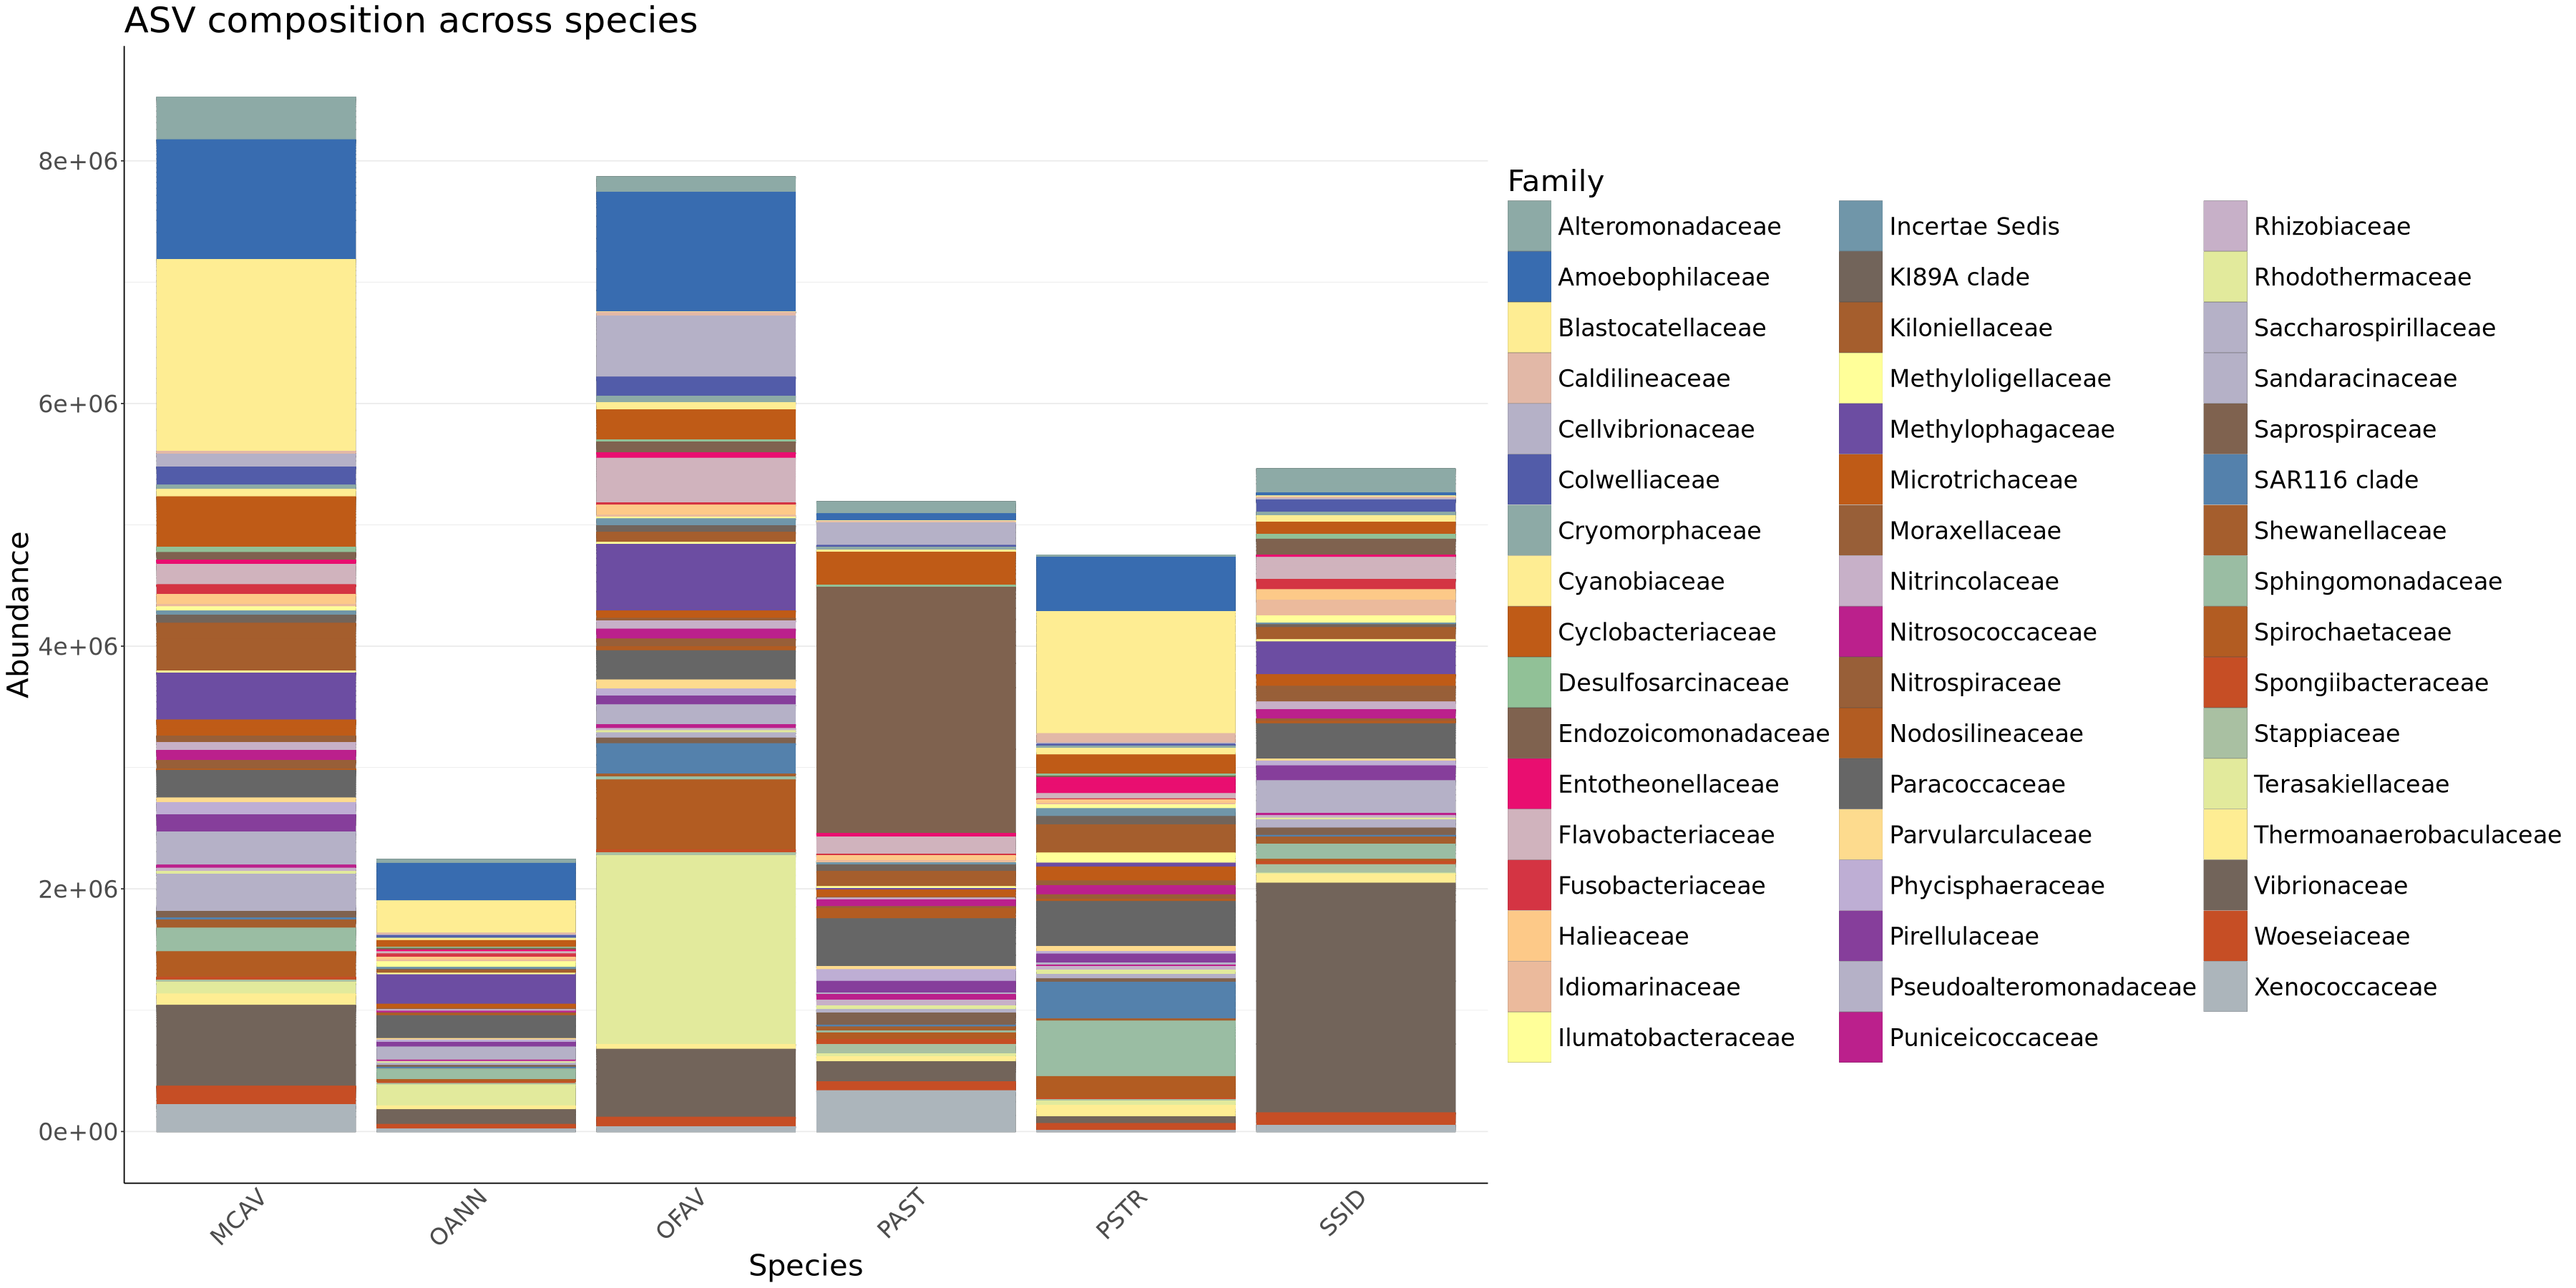

In [35]:
fam <- plot_bar(ps_fam, x="species", fill = "Family") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  labs(title = "ASV composition across species",
       x = "Species",
       y = "Abundance",
       color = "Family") +
  scale_fill_manual(values = famcolors, drop = TRUE) +
  scale_color_manual(values = famcolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    legend.title = element_text(size = 25),
  legend.text = element_text(size = 20),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 25)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
fam

In [36]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/species_family.png", plot = fam, width = 32, height = 15, units = "in", dpi = 300)

#### this one shows the x axis as all samples

In [60]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/all_family.png", plot = all, width = 32, height = 15, units = "in", dpi = 300)

In [106]:
#confrim chronological order worked
levels(sample_data(ps_past)$MonthYear)

[1] "Jun 2019" "Sep 2023" "Dec 2023"

### top 50 fam plots for each species/ facet by colony

#### past

Warning message in geom_text(aes(label = Family, fill = Family), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


<Guides[1] ggproto object>

colour : <GuideLegend>

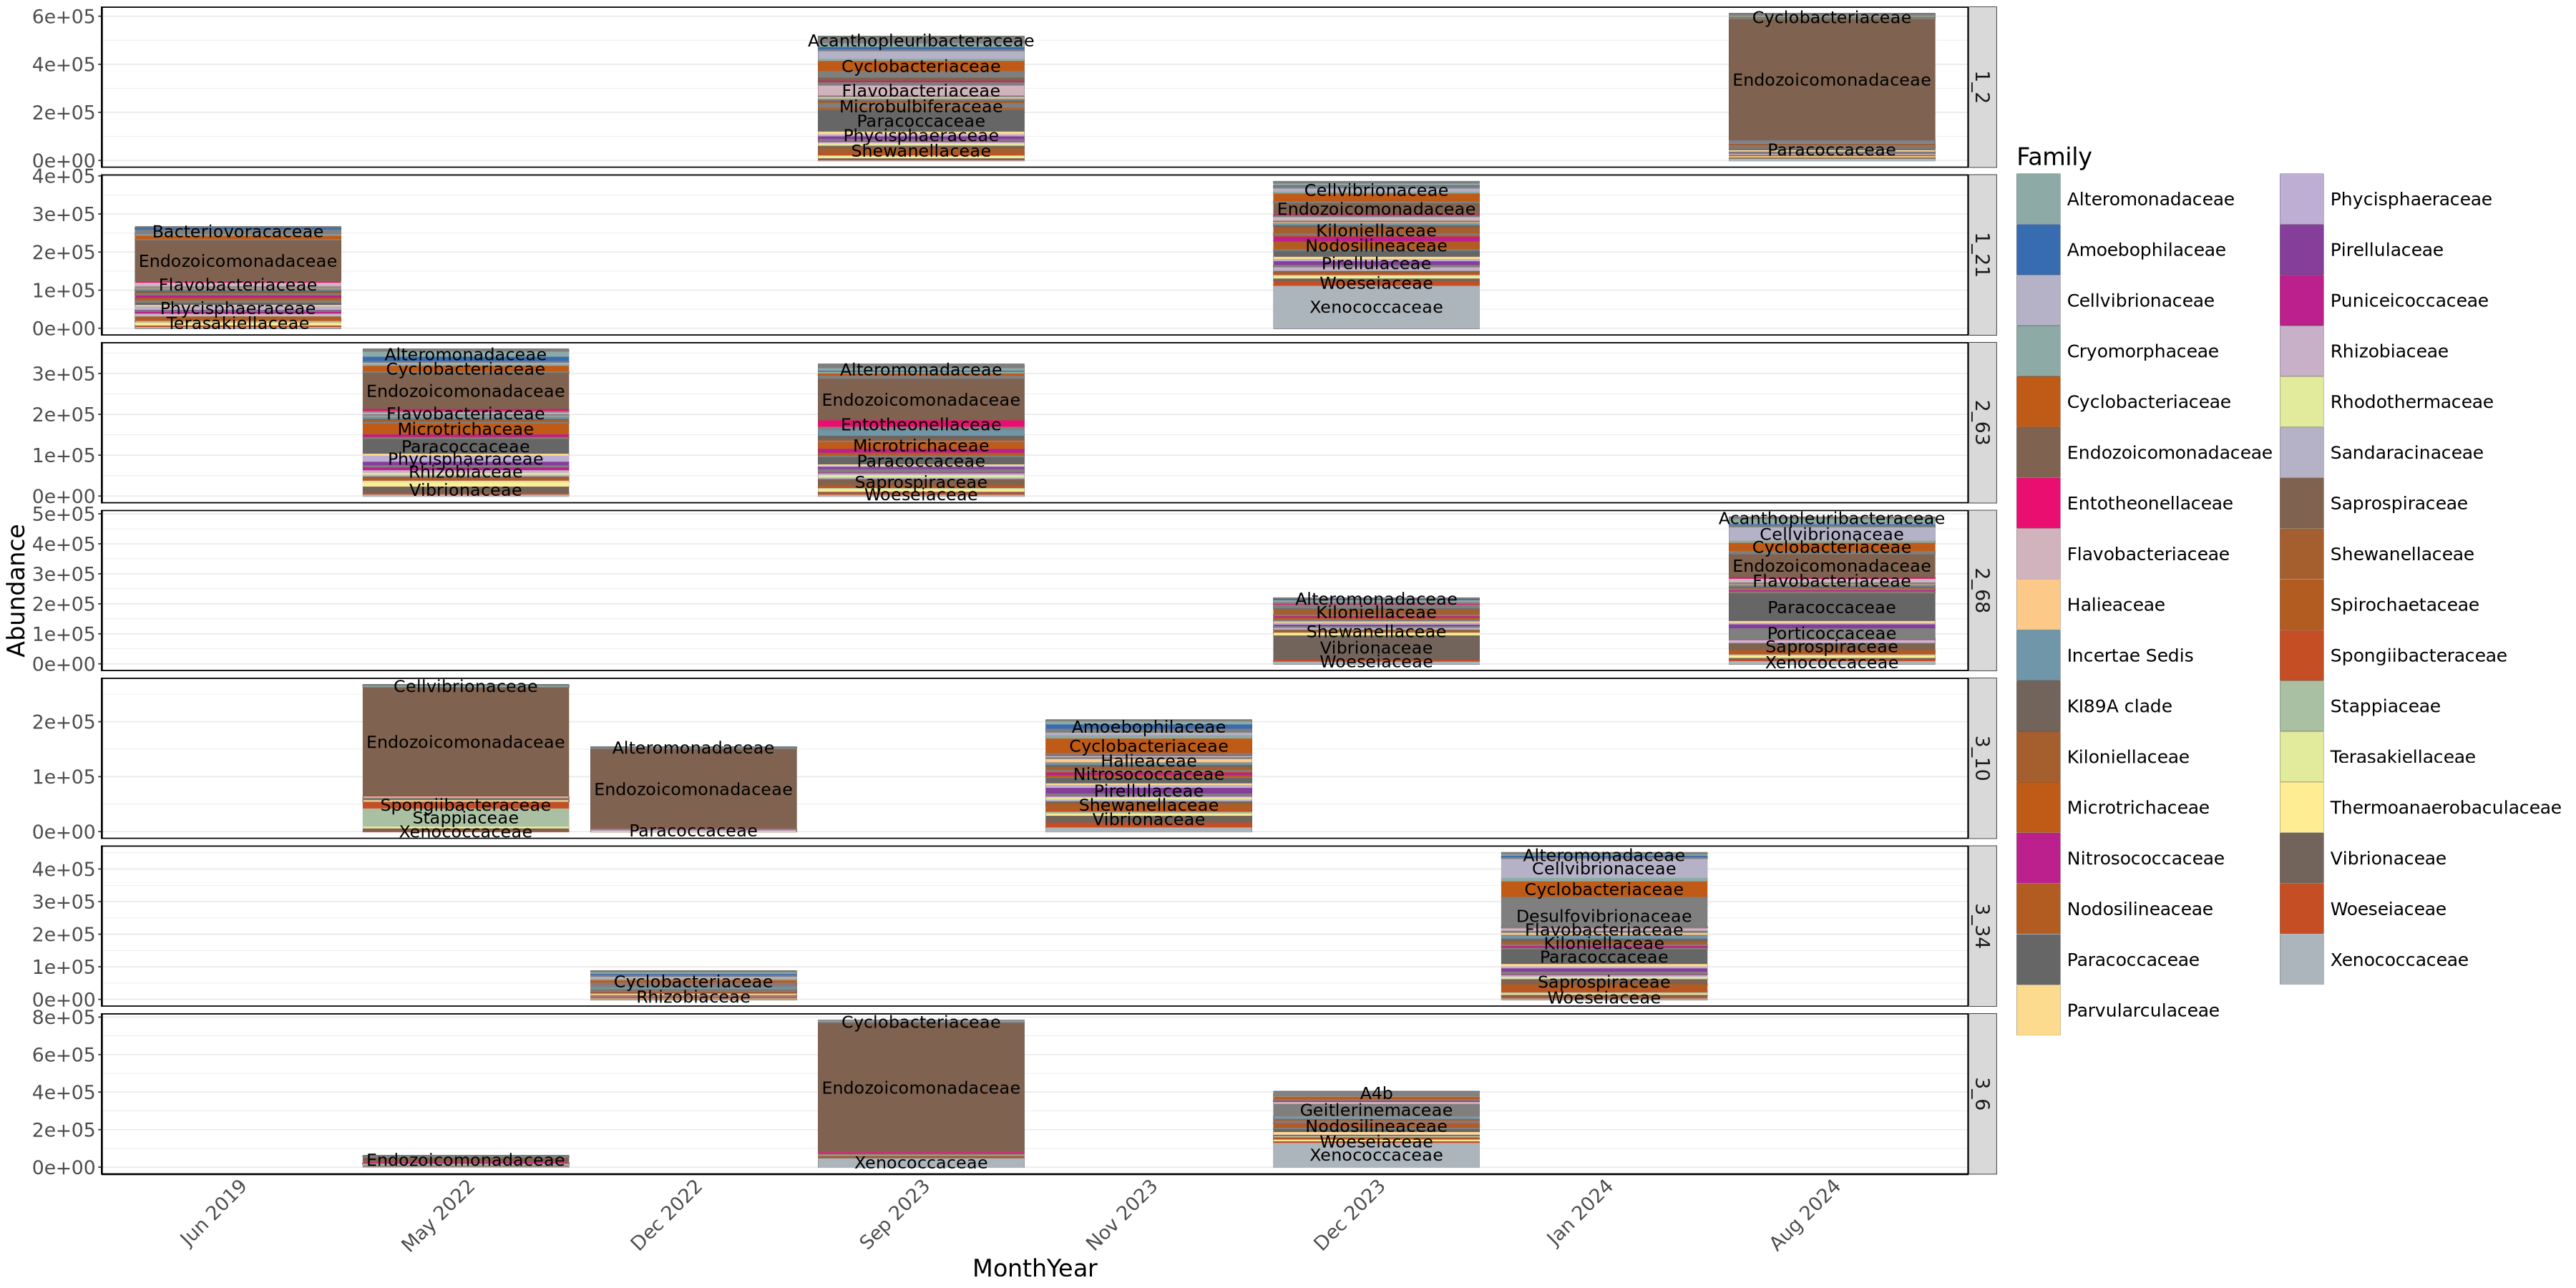

In [37]:
ps_past=tax_glom(ps_past, taxrank= "Family")

top50_past <- names(sort(taxa_sums(ps_past), decreasing=TRUE))[1:50] 
top50_past <- prune_taxa(top50_past, ps_past) 

#plot
past <- plot_bar(top50_past, x="MonthYear", fill = "Family") +
  facet_wrap(colony ~., strip.position = "right", ncol = 1, scales = "free_y") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Family, fill = Family),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = famcolors, drop = TRUE) +
  scale_color_manual(values = famcolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 20)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
past

In [38]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/past_family.png", plot = past, width = 32, height = 15, units = "in", dpi = 300)

#### pstr

Warning message in geom_text(aes(label = Family, fill = Family), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


<Guides[1] ggproto object>

colour : <GuideLegend>

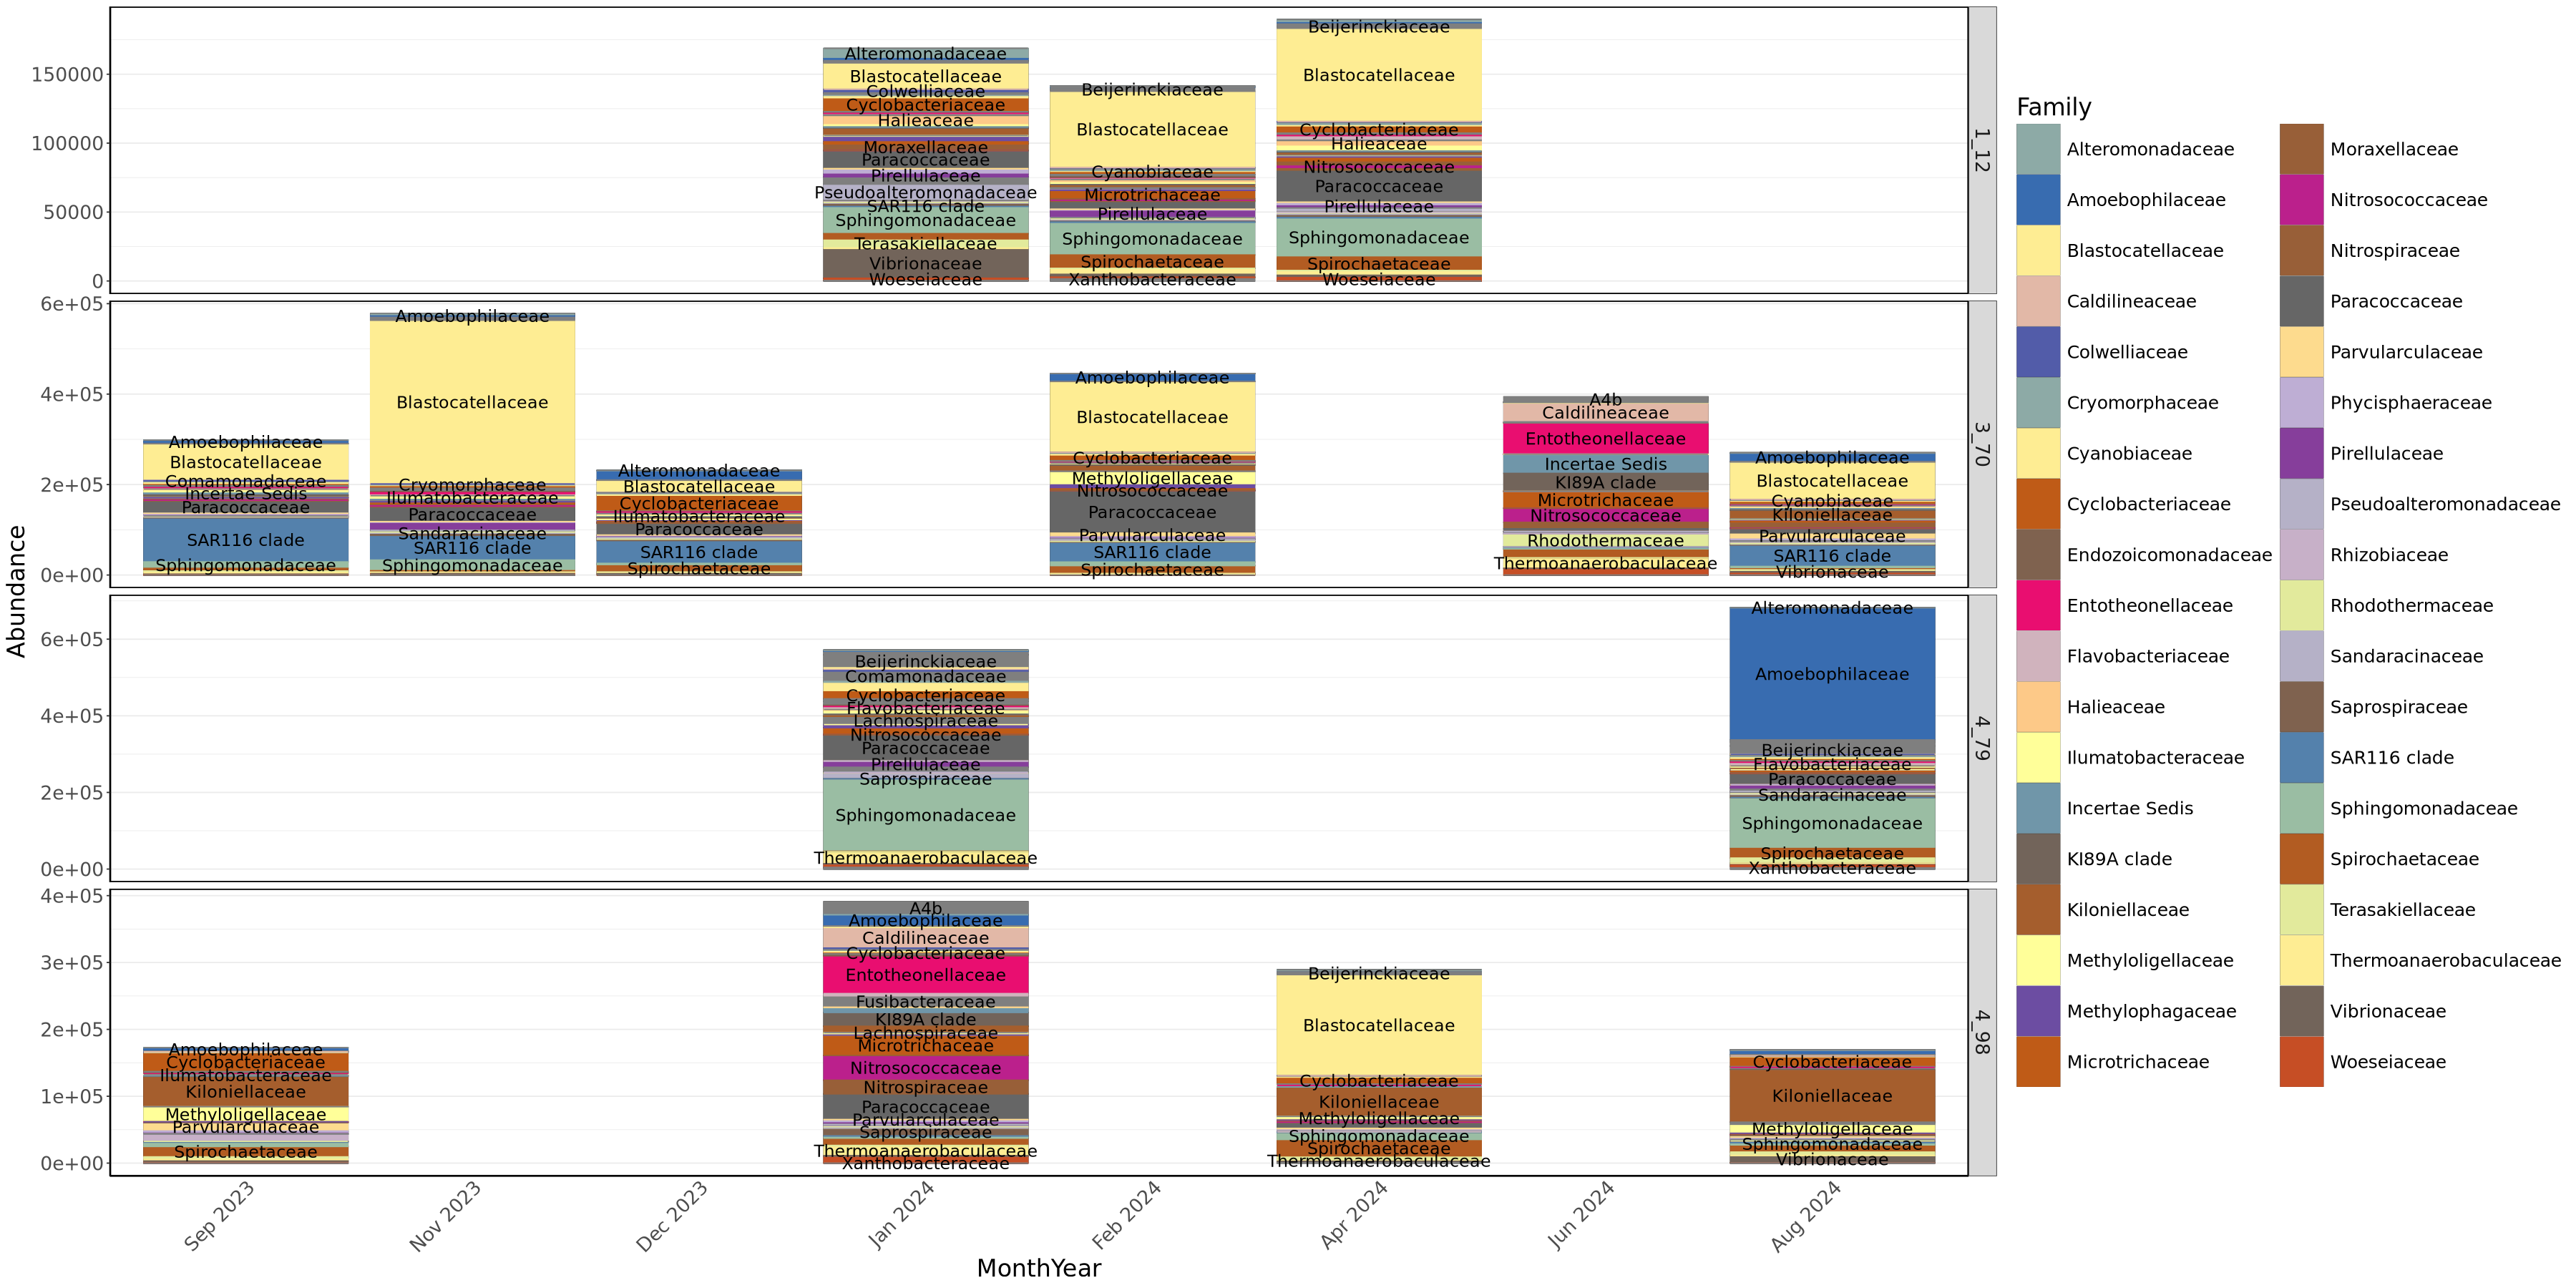

In [39]:
#plot
fam_pstr=tax_glom(ps_pstr, taxrank= "Family")

top50_pstr <- names(sort(taxa_sums(fam_pstr), decreasing=TRUE))[1:50] 
fam_pstr <- prune_taxa(top50_pstr, fam_pstr) 
fam_pstr <- plot_bar(fam_pstr, x="MonthYear", fill="Family") +
   facet_wrap(colony ~., strip.position = "right", ncol = 1, scales = "free_y") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Family, fill = Family),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = famcolors, drop = TRUE) +
  scale_color_manual(values = famcolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 20)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
fam_pstr

In [41]:
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/pstr_family.png", plot = fam_pstr, width = 32, height = 15, units = "in", dpi = 300)

Warning message in geom_text(aes(label = Family, fill = Family), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


<Guides[1] ggproto object>

colour : <GuideLegend>

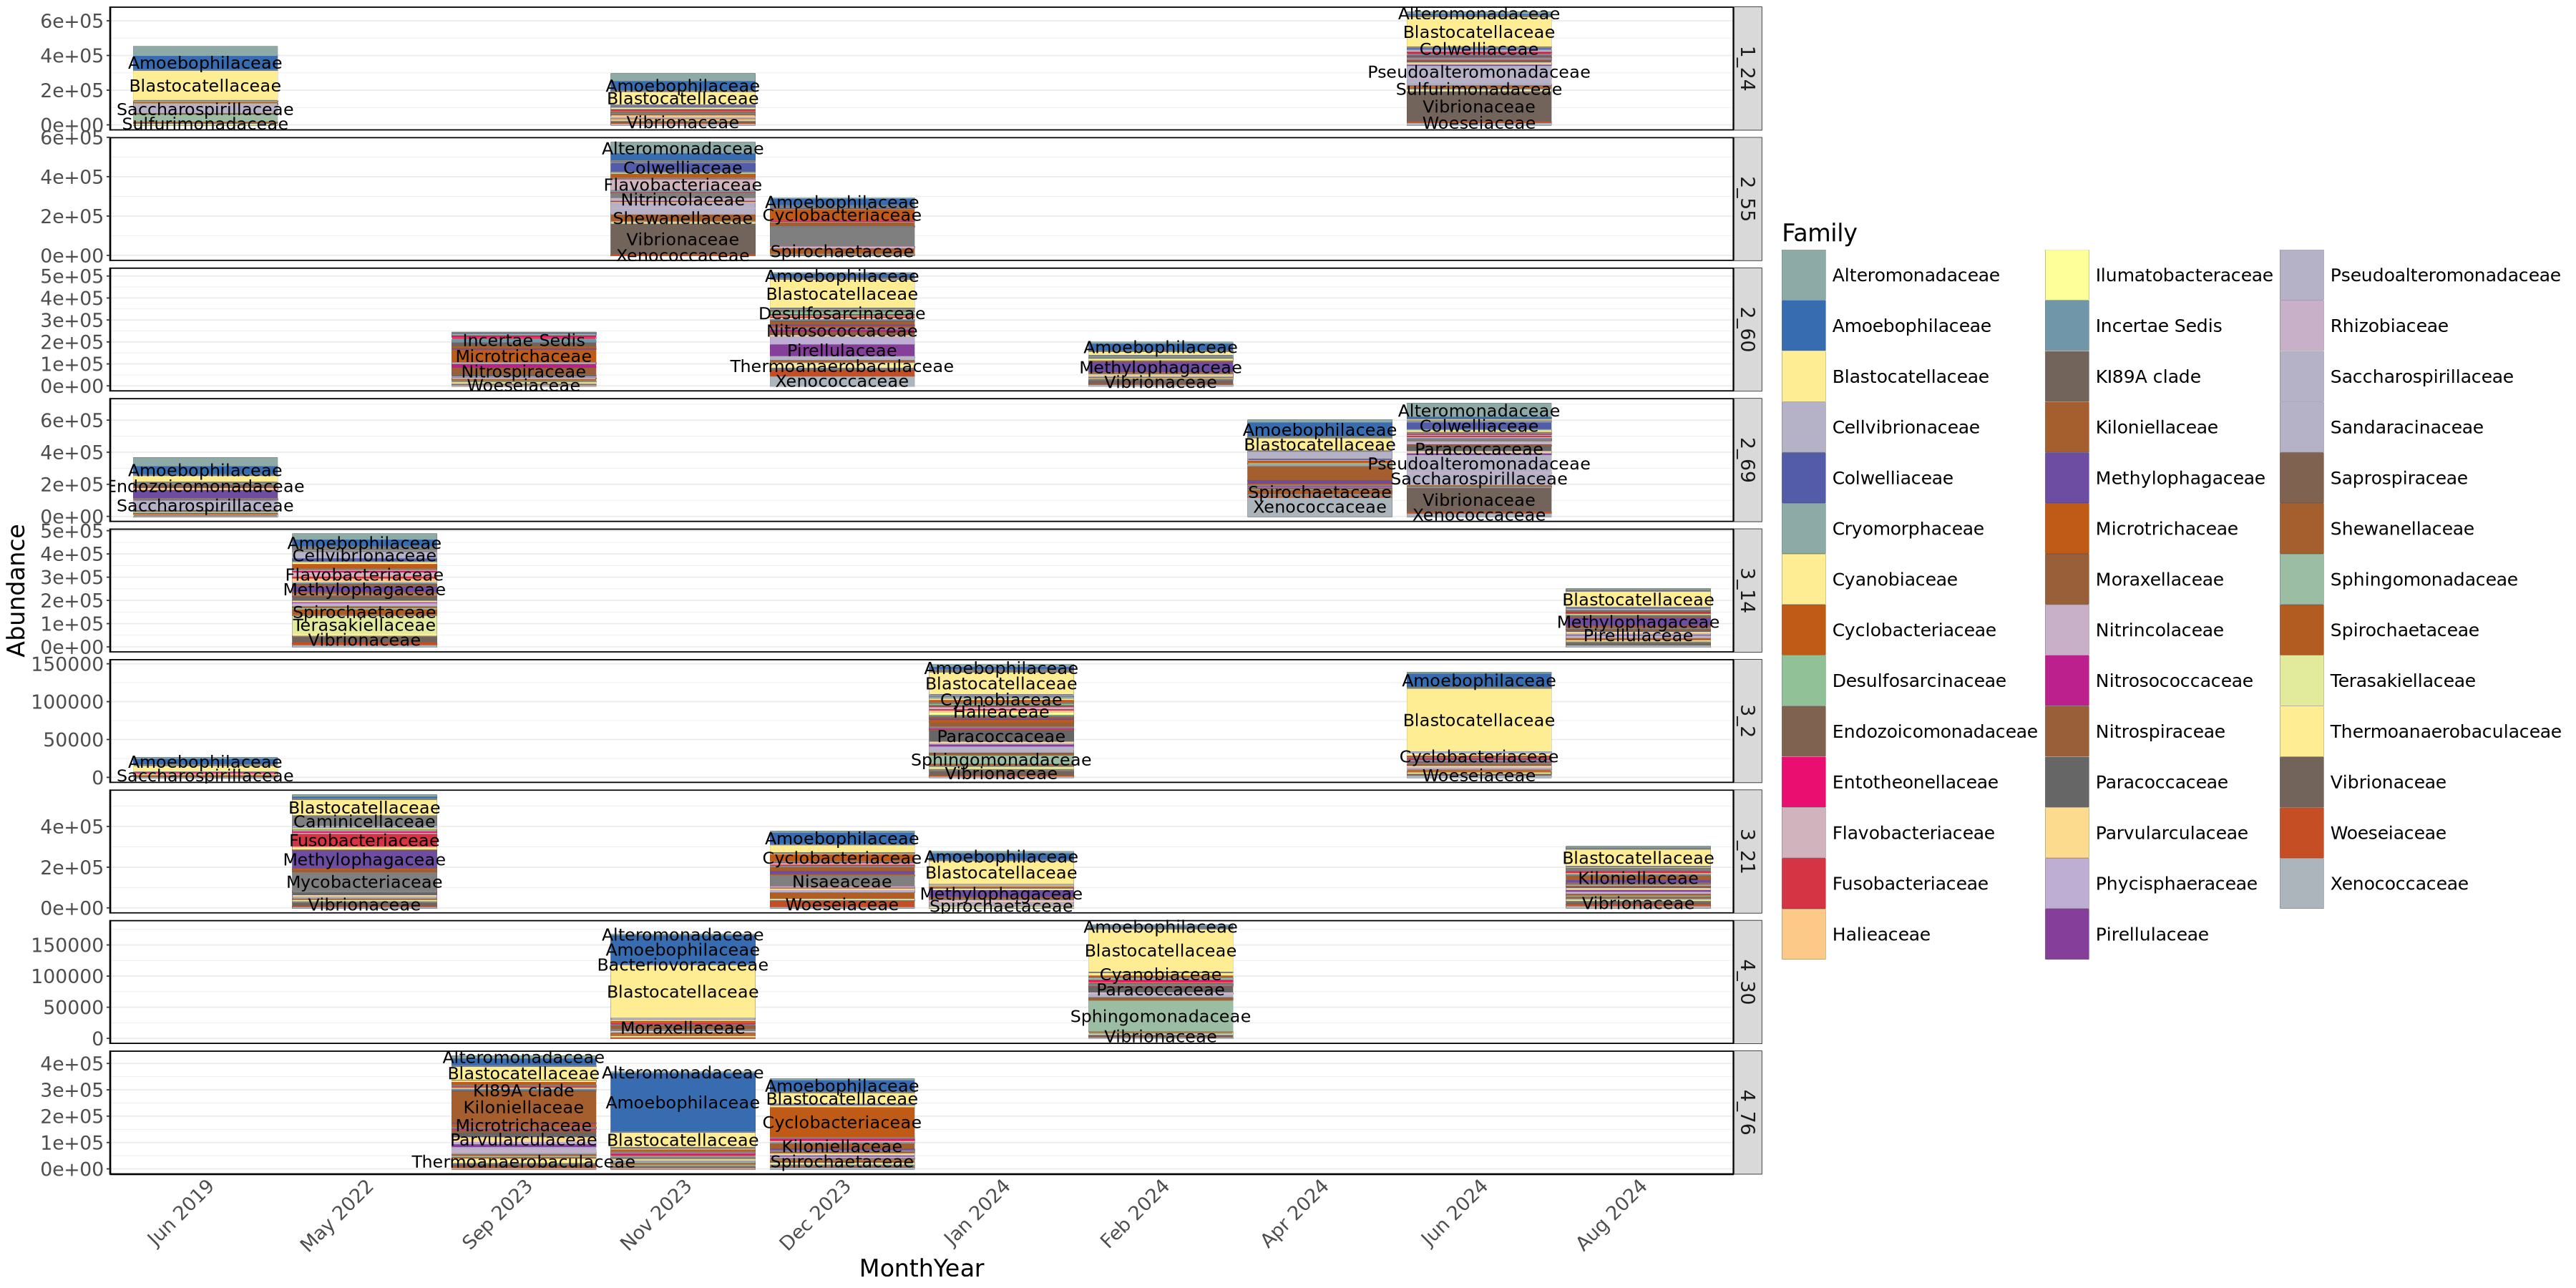

In [40]:
#plot
fam_mcav=tax_glom(ps_mcav, taxrank= "Family")

top50_mcav <- names(sort(taxa_sums(fam_mcav), decreasing=TRUE))[1:50] 
fam_mcav  <- prune_taxa(top50_mcav, fam_mcav) 
fam_mcav  <- plot_bar(fam_mcav , x="MonthYear", fill="Family") +
   facet_wrap(colony ~., strip.position = "right", ncol = 1, scales = "free_y") +
  geom_bar(aes(color = Family, fill = Family), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Family, fill = Family),
            position = position_stack(vjust = 0.5),
            color = "black", size = 5, check_overlap = TRUE) +
  scale_fill_manual(values = famcolors, drop = TRUE) +
  scale_color_manual(values = famcolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 20)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
fam_mcav 

In [42]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/mcav_family.png", plot = fam_mcav, width = 32, height = 15, units = "in", dpi = 300)

## Phylum plots
showing that PAST microbiome differences are conserved all the way to phylum

In [57]:
    # how many unique family taxa are there?
length(unique(tax_table(ps_clean)[, "Phylum"]))

[1] 46

In [58]:
#no need to reduce,  bc theyre are already less than 50
ps_phy=tax_glom(ps_clean, taxrank= "Phylum")

In [63]:
#color assignment
phycolors= colorRampPalette(brewer.pal(8, "Accent"))(46)

# Generate a random set of colors
phy_taxa <- unique(tax_table(ps_clean)[, "Phylum"])

    phycolors <- sample(phycolors, 46, length(phy_taxa))
    # naming my color palette so the random order stays the same
    phycolors<- setNames(phycolors, phy_taxa)

<Guides[1] ggproto object>

colour : <GuideLegend>

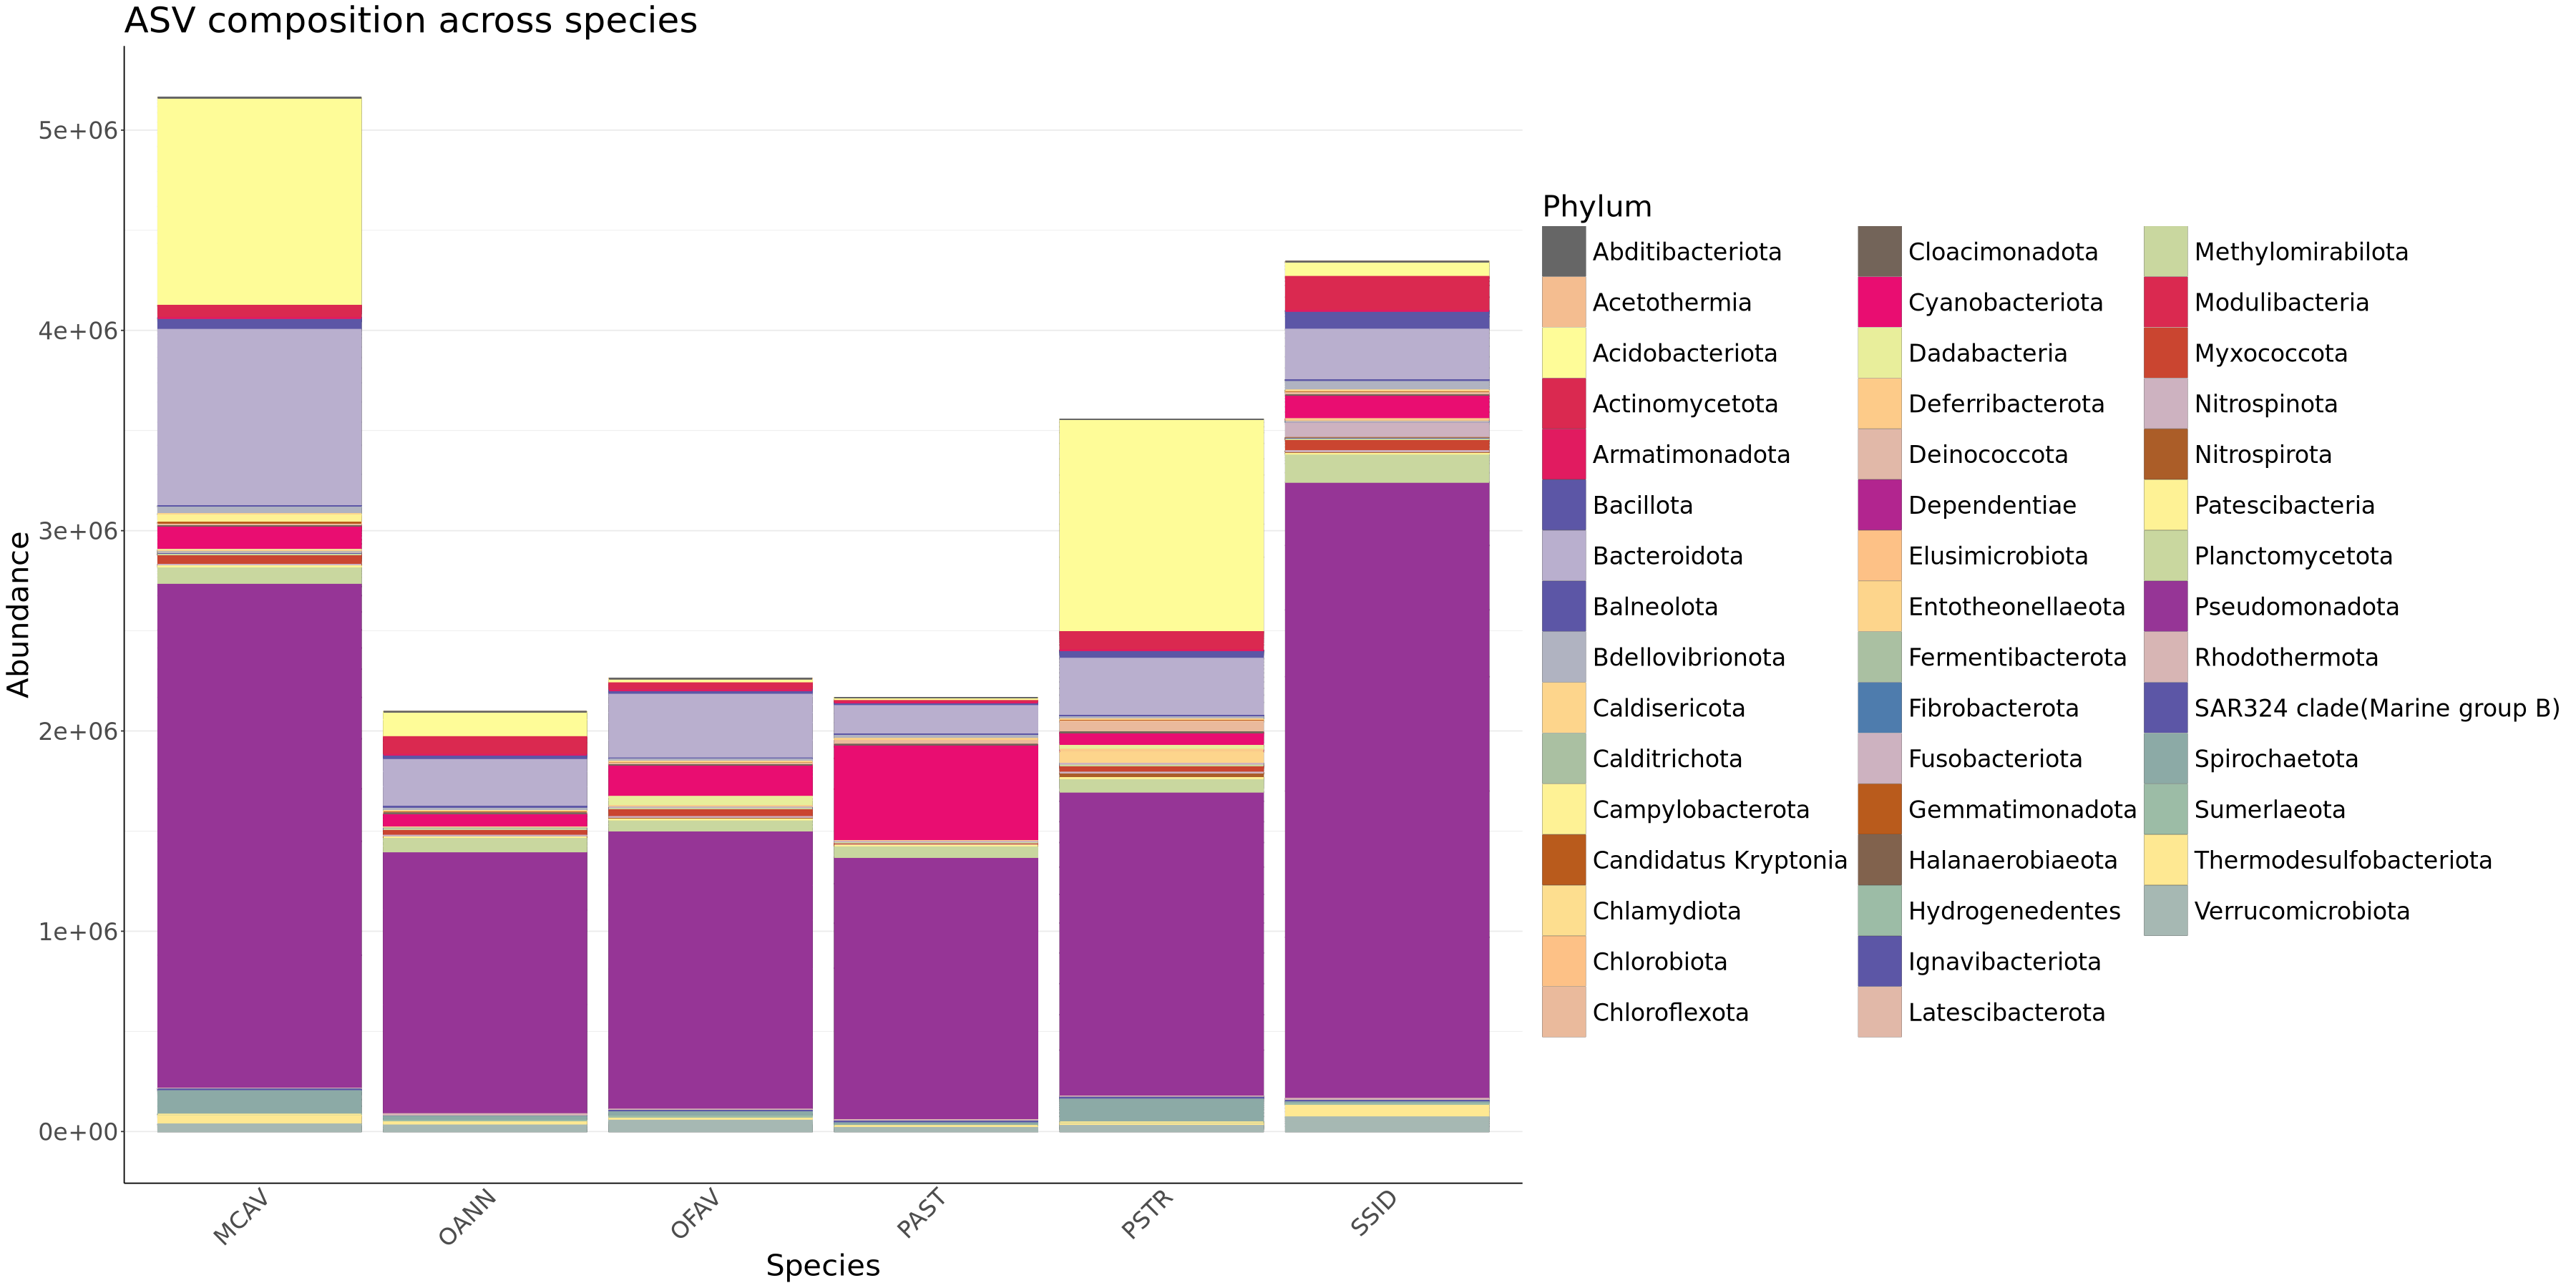

In [64]:
phy <- plot_bar(ps_phy, x="species", fill = "Phylum") +
  geom_bar(aes(color = Phylum, fill = Phylum), 
           stat = "identity", position = "stack") +
  labs(title = "ASV composition across species",
       x = "Species",
       y = "Abundance",
       color = "Phylum") +
  scale_fill_manual(values = phycolors, drop = TRUE) +
  scale_color_manual(values = phycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    legend.title = element_text(size = 25),
  legend.text = element_text(size = 20),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 25)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
phy

## Class plot, normalized asv abundance over time facetted by species

In [43]:
    # how many unique class taxa are there?
length(unique(tax_table(ps_clean)[, "Class"]))

[1] 89

In [44]:
#lets capture all the class taxa
ps_cla=tax_glom(ps_clean, taxrank= "Class")

In [46]:
#color assignment
clacolors= colorRampPalette(brewer.pal(9, "Set1"))(89)

# Generate a random set of colors
cla_taxa <- unique(tax_table(ps_clean)[, "Class"])

    clacolors <- sample(clacolors, 89, length(cla_taxa))
    # naming my color palette so the random order stays the same
    clacolors<- setNames(clacolors, cla_taxa)

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


<Guides[1] ggproto object>

colour : <GuideLegend>

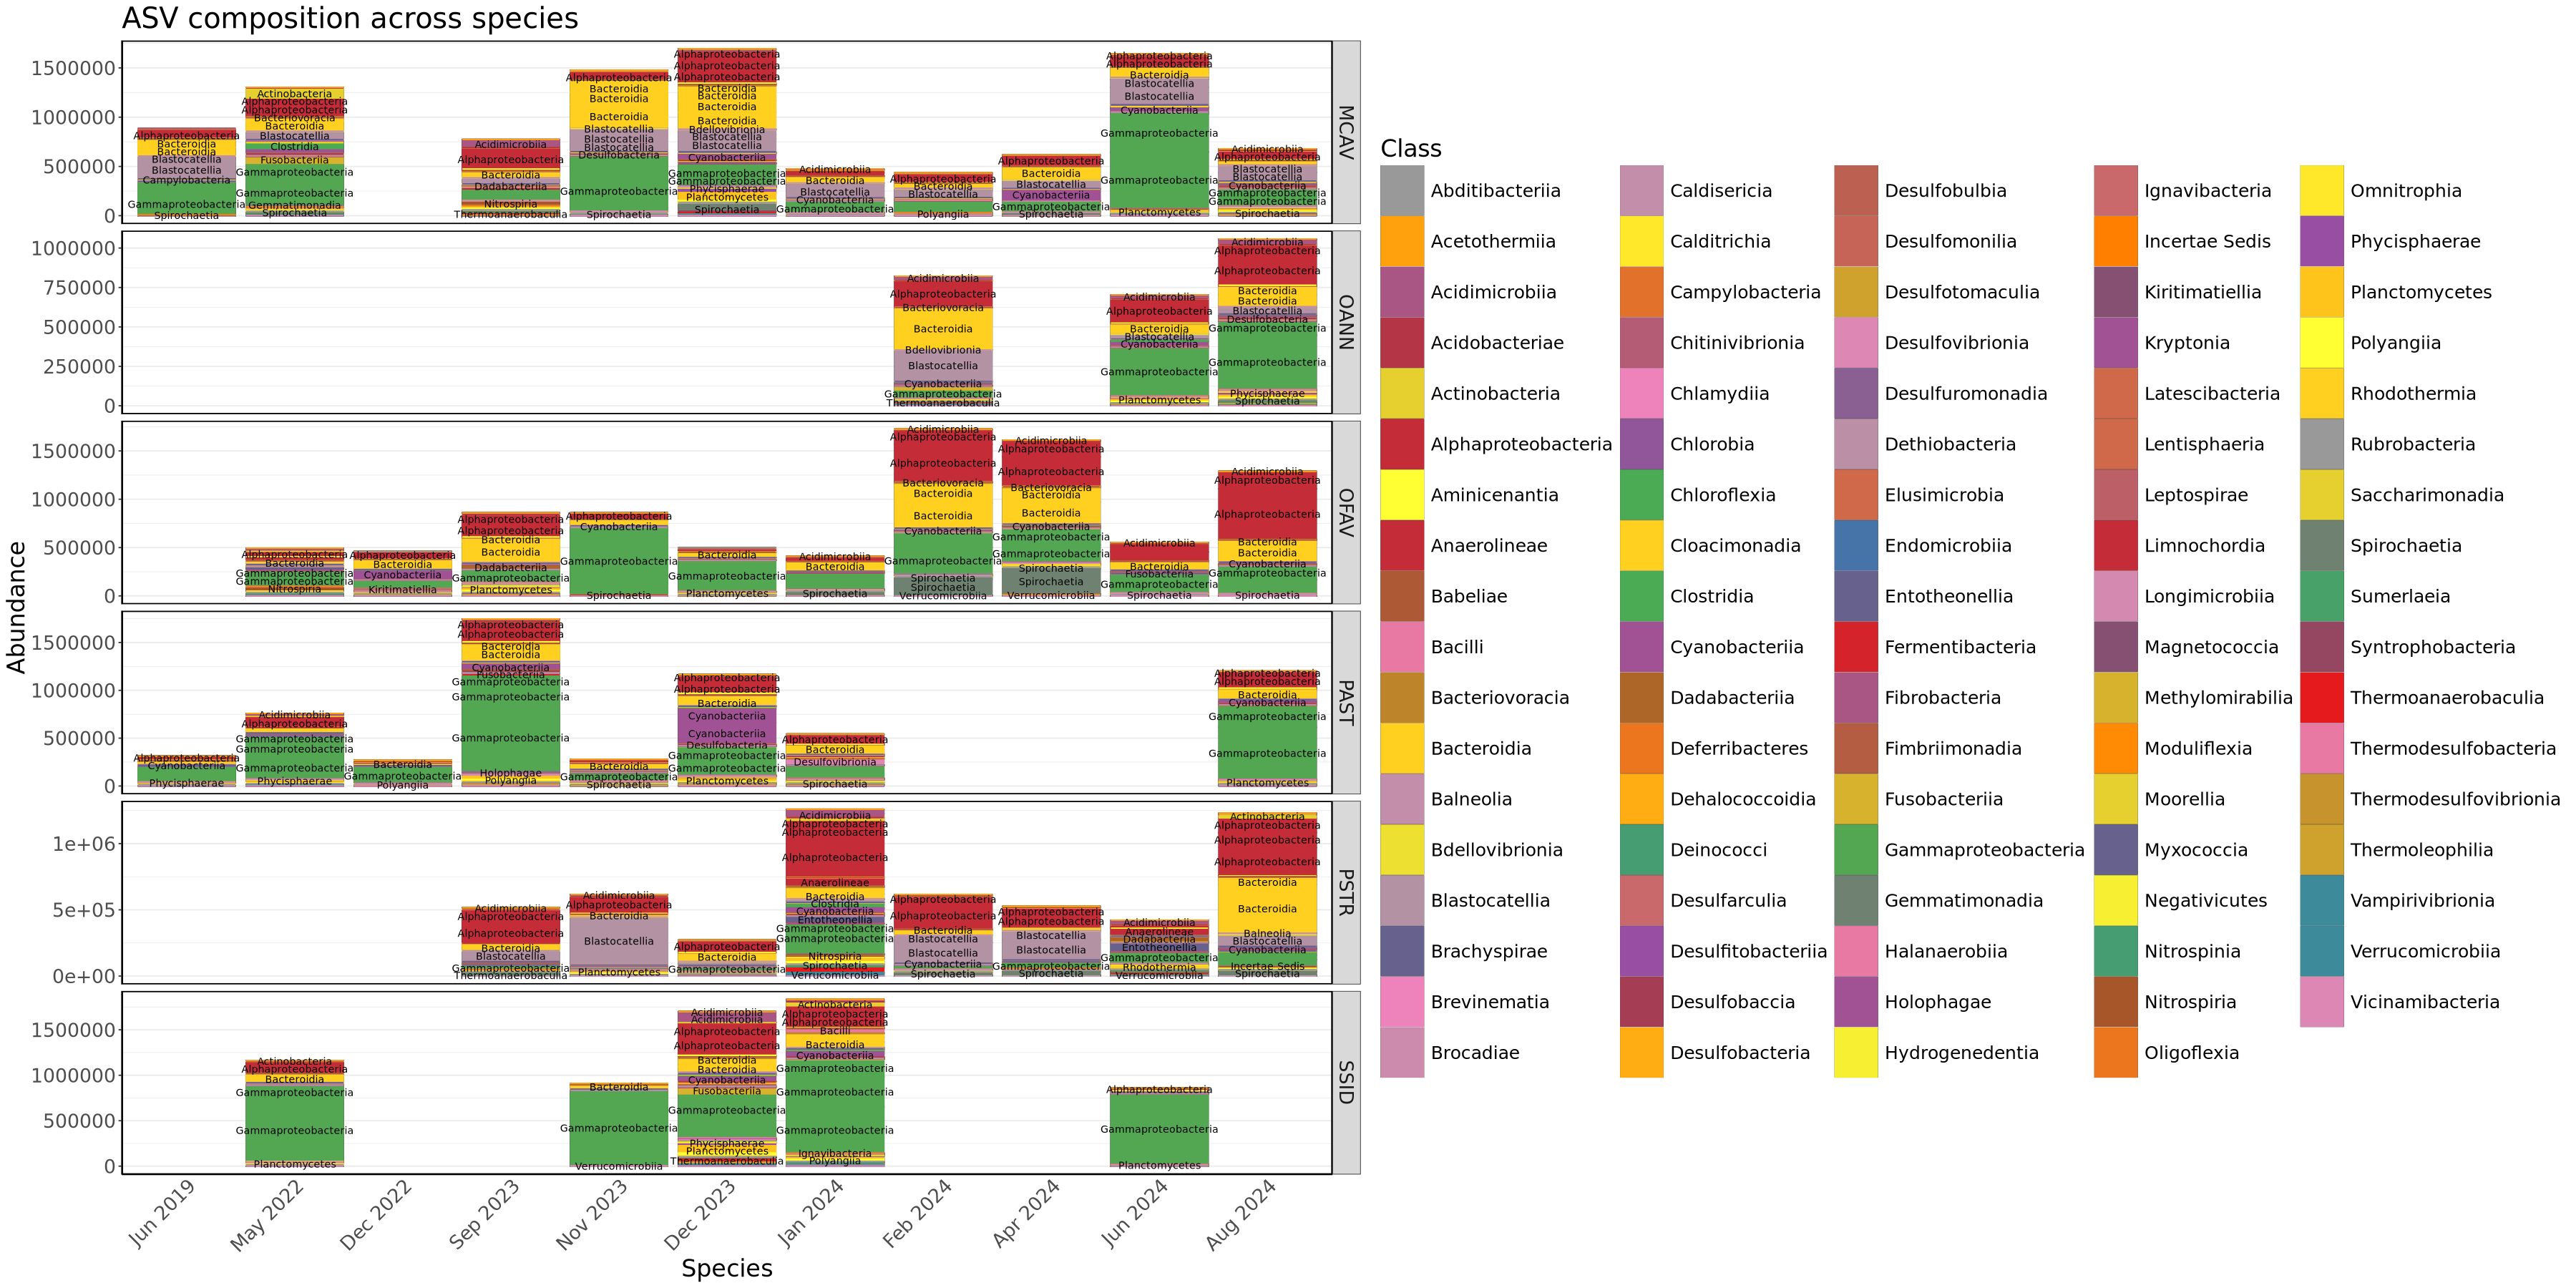

In [47]:
cla<- plot_bar(ps_cla, x="MonthYear", fill = "Class") +
facet_wrap(species ~., strip.position = "right", ncol = 1, scales = "free_y") +
  geom_bar(aes(color = Class, fill = Class), 
           stat = "identity", position = "stack") +
geom_text(aes(label = Class, fill = Class),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  labs(title = "ASV composition across species",
       x = "Species",
       y = "Abundance",
       color = "Class") +
  scale_fill_manual(values = clacolors, drop = TRUE) +
  scale_color_manual(values = clacolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 20)
  )
guides(color = guide_legend(override.aes = list(size = 6))) 
cla

In [48]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/species_class_overtime.png", plot = cla, width = 32, height = 15, units = "in", dpi = 300)

## first plots

In [39]:
ps_past=tax_glom(ps_past, taxrank="Class")

top100_past <- names(sort(taxa_sums(ps_past), decreasing=TRUE))[1:100] 
top100_past <- prune_taxa(top100_past, ps_past) 

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


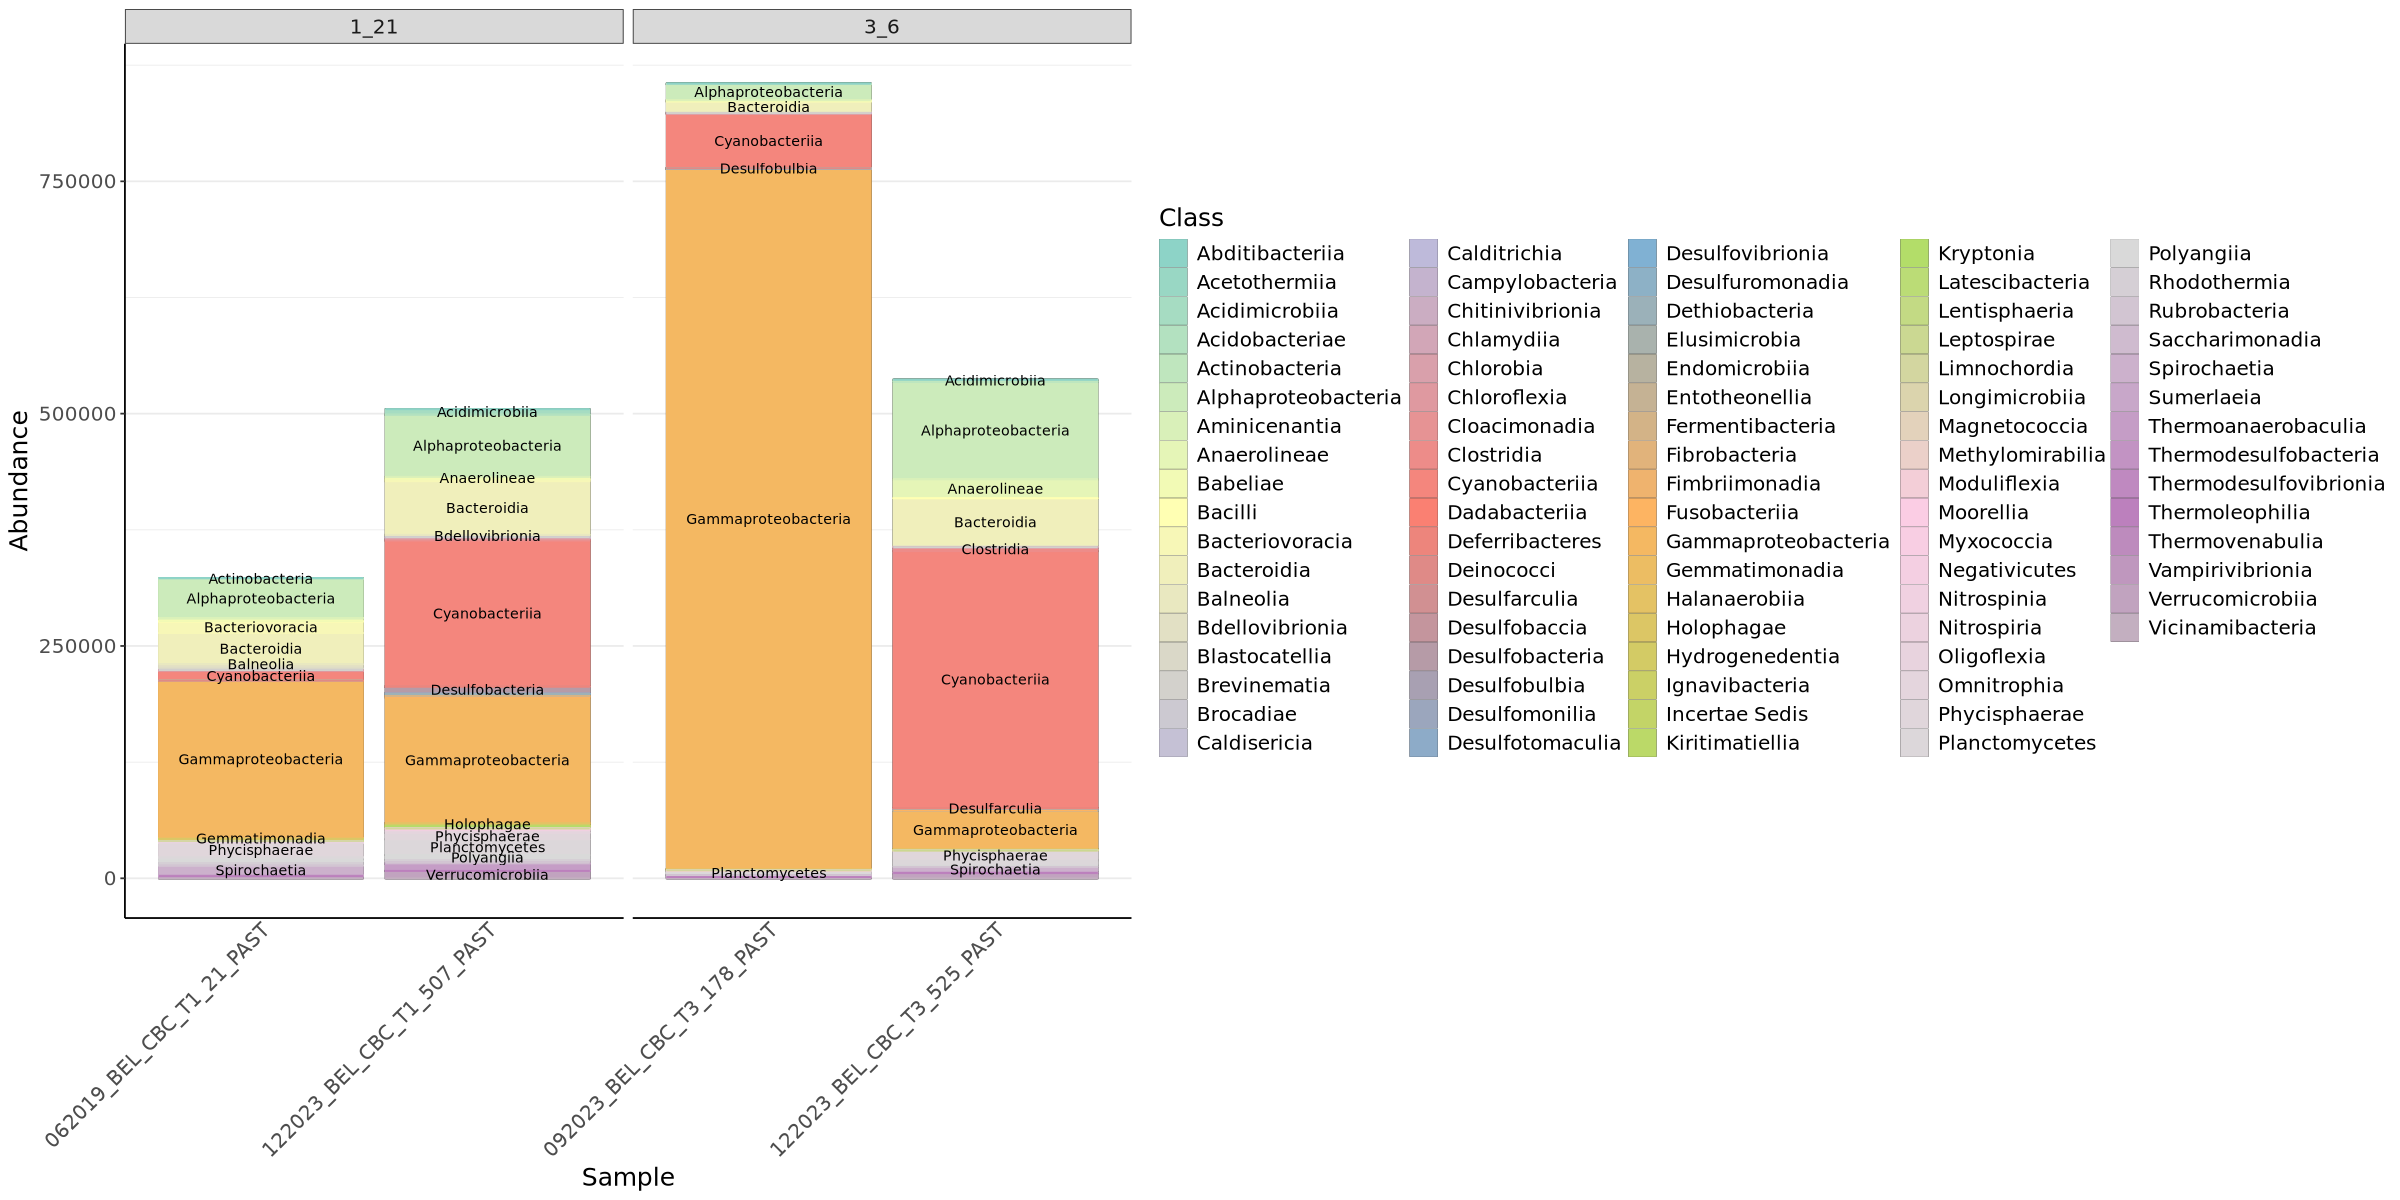

In [40]:
#plot
past <- plot_bar(top100_past, fill = "Class") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Class, fill = Class), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Class, fill = Class),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 15)
  )
past

In [41]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/plot_past_class.png", plot = past, width = 20, height = 10, units = "in", dpi = 300)

Warning message in geom_text(aes(label = Class, fill = Class), position = position_stack(vjust = 0.5), :
“Ignoring unknown aesthetics: fill”


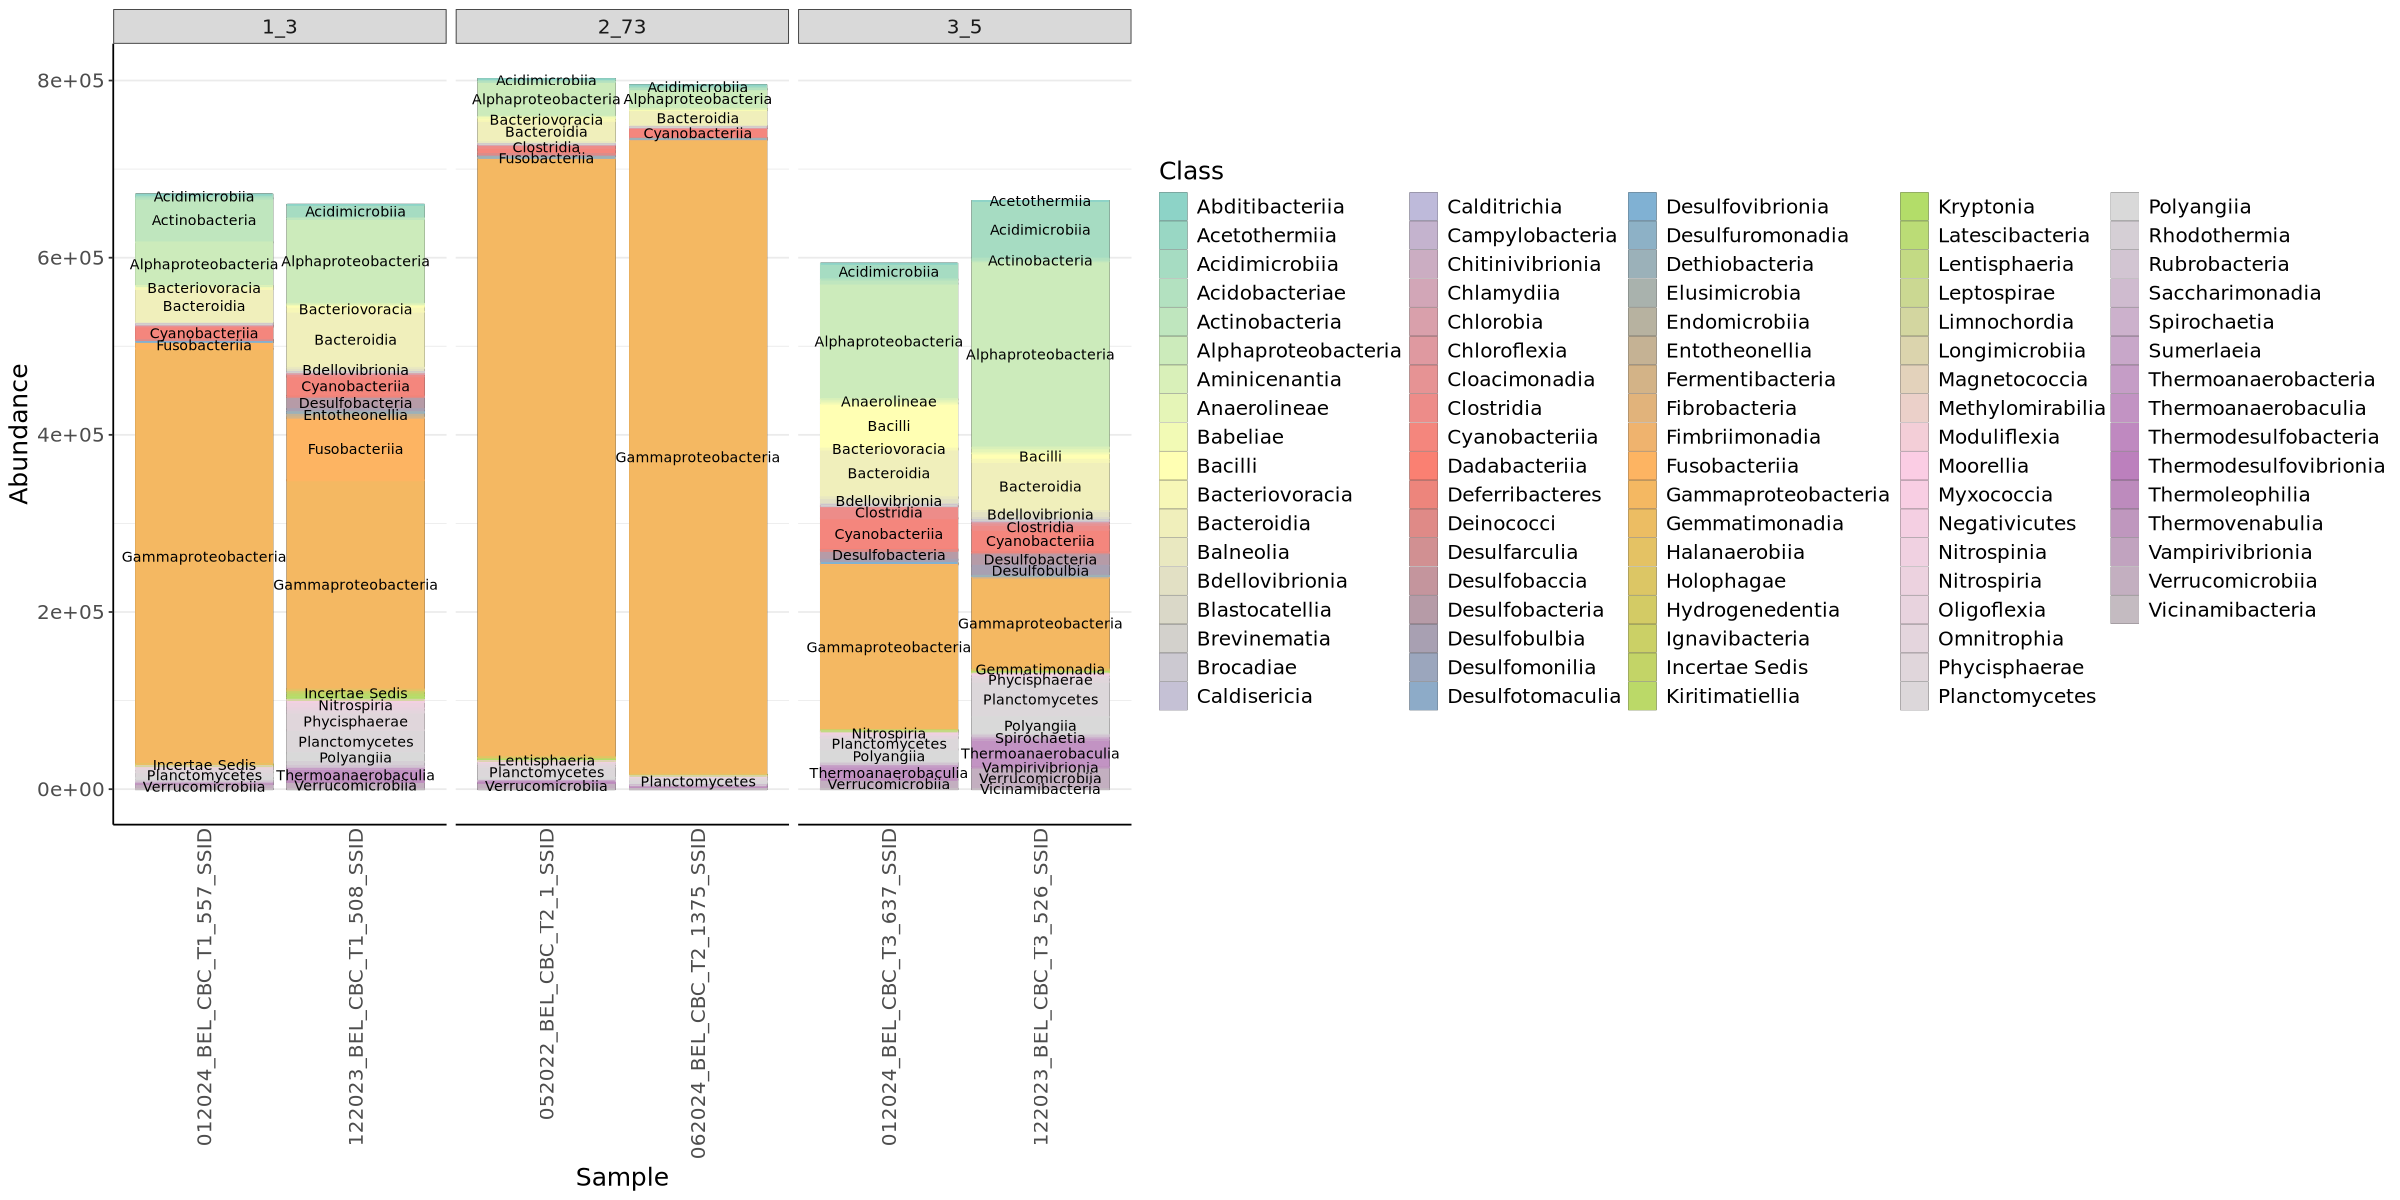

In [75]:
ps_ssid=tax_glom(ps_ssid, taxrank="Class")

top100_ssid <- names(sort(taxa_sums(ps_ssid), decreasing=TRUE))[1:100] 
top100_ssid <- prune_taxa(top100_ssid, ps_ssid) 

#plot
plot_bar(top100_ssid, fill = "Class") +
  facet_grid(. ~ colony, scales = "free_x") +
  geom_bar(aes(color = Class, fill = Class), 
           stat = "identity", position = "stack") +
  geom_text(aes(label = Class, fill = Class),
            position = position_stack(vjust = 0.5),
            color = "black", size = 3, check_overlap = TRUE) +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
  theme(
    legend.position = "right",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    text = element_text(size = 15)
  )